[View in Colaboratory](https://colab.research.google.com/github/RichardDeetlefs/TrainMyNet/blob/master/dcgan_mnist.ipynb)

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
random_img = np.random.randint(len(train_data))
print(train_data.shape)
print(max(train_data[random_img]))
print(min(train_data[random_img]))

(55000, 784)
1.0
0.0


In [11]:
#scale data to range [-1,1] --> as we use tanh activation in the output of the generated images. 
train_images =  train_data*2 - 1
print(max(train_images[random_img]))
print(min(train_images[random_img]))

1.0
-1.0


In [0]:
kernel_size = [5,5]
stride = [2,2]

def gen(input_tensor, reuse=False):#input tensor is z: [-1, 100]
    with tf.variable_scope('generator'):
        act_fun_g = tf.nn.relu

        fully = tf.layers.dense(input_tensor, 
                                7*7*64,
                                activation=act_fun_g,
                                reuse=reuse,
                                name='g_hid1')
        fully_r = tf.reshape(fully, shape=[-1,7,7,64])

        cnn_T_layer1 = tf.layers.conv2d_transpose(fully_r, 32, kernel_size, strides=stride,
                                                  padding='same',
                                                  activation=act_fun_g,
                                                  reuse=reuse,
                                                  name='g_CNN_T1')#image is now double the size --> 14x14
        
        cnn_T_layer2 = tf.layers.conv2d_transpose(cnn_T_layer1, 1, kernel_size, strides=stride,
                                                  padding='same',
                                                  activation=None,
                                                  reuse=reuse,
                                                  name='g_CNN_T2')#image is now double the size --> 28x28

        output = tf.reshape(cnn_T_layer2,[-1, 784])
        return tf.nn.tanh(output)

In [0]:
def dis(input_tensor, reuse=False):#input_tensor is an image [-1, 784]
    with tf.variable_scope('discriminator'):
        act_fun_d = tf.nn.leaky_relu#default leak: alpha = 0.2

        input_tensor_r = tf.reshape(input_tensor, shape=[-1, 28, 28, 1])

        cnn_layer1 = tf.layers.conv2d(input_tensor_r, 32, kernel_size, strides=stride,
                                      padding='same',
                                      activation=act_fun_d,
                                      reuse=reuse,
                                      name='d_CNN1')#image is now half the size --> 14x14

        cnn_layer2 = tf.layers.conv2d(cnn_layer1, 64, kernel_size, strides=stride,
                                      padding='same',
                                      activation=act_fun_d,
                                      reuse=reuse,
                                      name='d_CNN2')#image is now half the size --> 7x7
        cnn_layer2_r = tf.reshape(cnn_layer2,[-1, 7*7*64])

        output = tf.layers.dense(cnn_layer2_r, 
                                 1,
                                 activation=None,
                                 reuse=reuse,
                                 name='d_out')

        return tf.nn.sigmoid(output)

In [0]:
def gen_train(d_fake, LR):
    with tf.variable_scope('', reuse=True):
        global_step = tf.get_variable('global_step',dtype=tf.int32)
  
    g_loss = tf.reduce_mean(-tf.log(d_fake))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=LR,beta1=0.5)
    g_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
    g_train = optimizer.minimize(g_loss, var_list=g_var, global_step=global_step)
    return g_train, g_loss

In [0]:
def dis_train(d_fake, d_real, LR):
    d_loss = -0.5*tf.reduce_mean((tf.log(d_real) + tf.log(1.0 - d_fake)))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=LR,beta1=0.5)
    d_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    d_train = optimizer.minimize(d_loss, var_list=d_var)
    return d_train, d_loss

In [0]:
def random_batch(x, batch_size):
    loc = np.random.randint(len(x), size=batch_size)
    return x[loc,:]

In [0]:
#run time!
z_dim = 100
LR = 0.0002
x_dim = 784
batch_size = 128

def training():
    with tf.Graph().as_default():
        sess = tf.Session()
        global_step = tf.get_variable('global_step', shape=[],dtype=tf.int32)
        
        x = tf.placeholder(tf.float32, [batch_size, x_dim], 'real-images')
        
        z = tf.random_normal([batch_size, z_dim], mean=0, stddev=1.0)#Latent: Gaussian
        
        gen_x = gen(z, reuse=False)
        
        d_fake = dis(gen_x, reuse=False)
        d_real = dis(x, reuse=True)
        
        g_train, g_loss = gen_train(d_fake, LR)
        d_train, d_loss = dis_train(d_fake, d_real, LR)
       
        initial_var = tf.global_variables_initializer()
        sess.run(initial_var)
        
        train = True
        step = 0
        
        while train == True:
            real_data = random_batch(train_images, batch_size)
            _g, _d = sess.run([g_train, d_train], feed_dict={x: real_data})
            
            if step % 100 == 0:
                loss_g, loss_d, gen_images = sess.run([g_loss, d_loss, gen_x], feed_dict={x: real_data})
                print()
                print('------------------------------------------------------------------------------')
                print('At step:', step)
                print('G loss =', loss_g)
                print('D loss =', loss_d)
                plt.subplot(1, 4, 1)
                plt.title('real')
                plt.imshow(np.reshape(real_data[0], [28,28]), cmap='gray')
                
                plt.subplot(1, 4, 2)
                plt.title('generated')
                plt.imshow(np.reshape(gen_images[0], [28,28]), cmap='gray')
                
                plt.subplot(1, 4, 3)
                plt.title('real')
                plt.imshow(np.reshape(real_data[1], [28,28]), cmap='gray')
                
                plt.subplot(1, 4, 4)
                plt.title('generated')
                plt.imshow(np.reshape(gen_images[1], [28,28]), cmap='gray')
                plt.show()
                
                
                
            step += 1
                


------------------------------------------------------------------------------
At step: 0
G loss = 0.6941142
D loss = 0.69037044


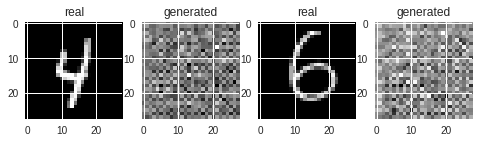


------------------------------------------------------------------------------
At step: 100
G loss = 1.0149353
D loss = 0.2635859


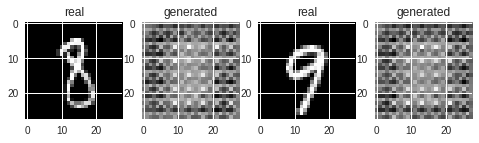


------------------------------------------------------------------------------
At step: 200
G loss = 1.5386472
D loss = 0.20003992


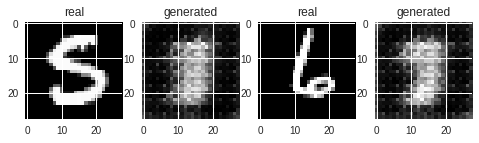


------------------------------------------------------------------------------
At step: 300
G loss = 2.2478702
D loss = 0.1709533


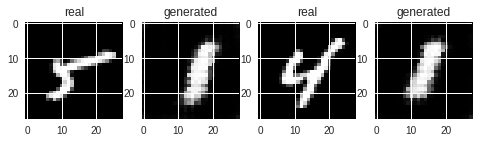


------------------------------------------------------------------------------
At step: 400
G loss = 2.0995271
D loss = 0.23620111


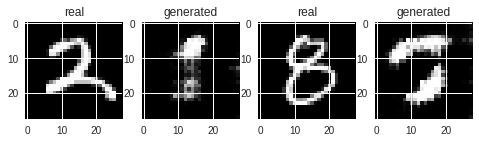


------------------------------------------------------------------------------
At step: 500
G loss = 1.9316726
D loss = 0.21911207


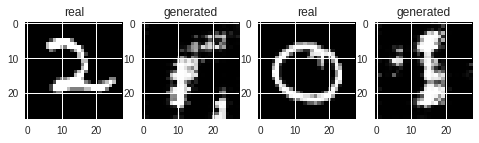


------------------------------------------------------------------------------
At step: 600
G loss = 1.8826123
D loss = 0.2915625


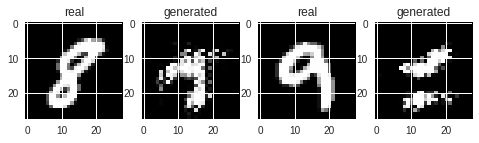


------------------------------------------------------------------------------
At step: 700
G loss = 1.6760802
D loss = 0.31421858


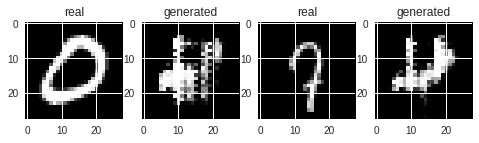


------------------------------------------------------------------------------
At step: 800
G loss = 0.86536384
D loss = 0.5482776


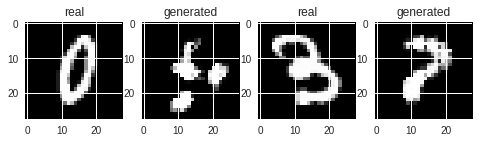


------------------------------------------------------------------------------
At step: 900
G loss = 1.8906114
D loss = 0.2391757


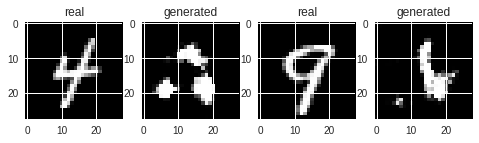


------------------------------------------------------------------------------
At step: 1000
G loss = 1.5312326
D loss = 0.37229517


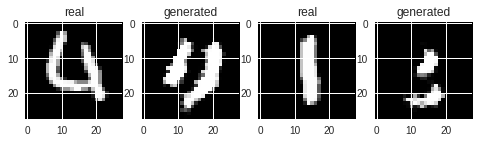


------------------------------------------------------------------------------
At step: 1100
G loss = 1.0605322
D loss = 0.46243244


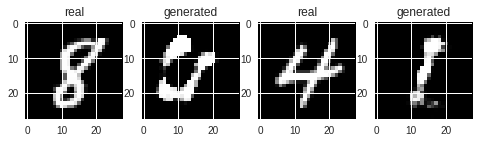


------------------------------------------------------------------------------
At step: 1200
G loss = 1.4479802
D loss = 0.39895874


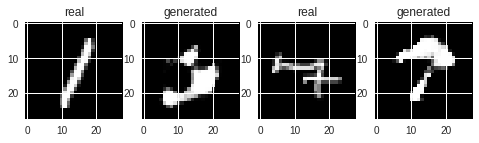


------------------------------------------------------------------------------
At step: 1300
G loss = 1.6218317
D loss = 0.32724744


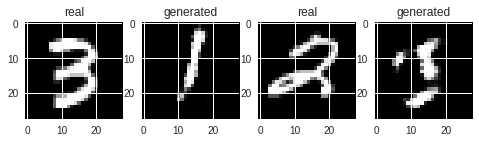


------------------------------------------------------------------------------
At step: 1400
G loss = 1.7610326
D loss = 0.3479272


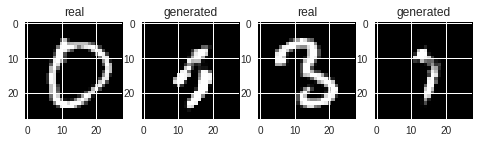


------------------------------------------------------------------------------
At step: 1500
G loss = 1.2983563
D loss = 0.3761041


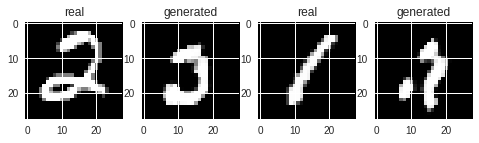


------------------------------------------------------------------------------
At step: 1600
G loss = 1.0813503
D loss = 0.42199337


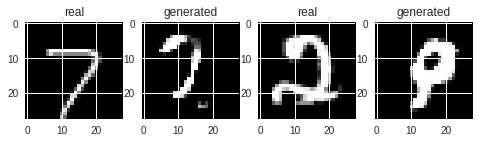


------------------------------------------------------------------------------
At step: 1700
G loss = 1.378901
D loss = 0.3357591


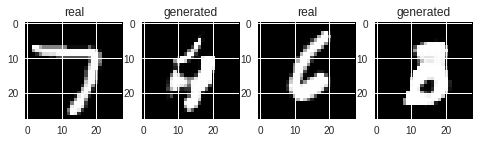


------------------------------------------------------------------------------
At step: 1800
G loss = 1.2504667
D loss = 0.3520475


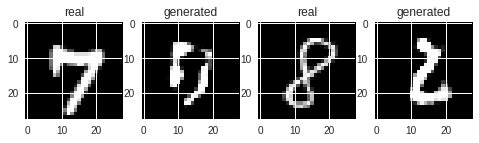


------------------------------------------------------------------------------
At step: 1900
G loss = 1.2426658
D loss = 0.37288052


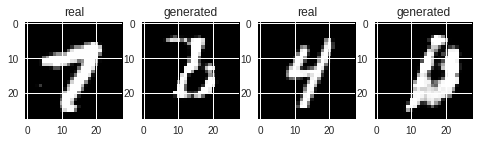


------------------------------------------------------------------------------
At step: 2000
G loss = 1.5705246
D loss = 0.3948955


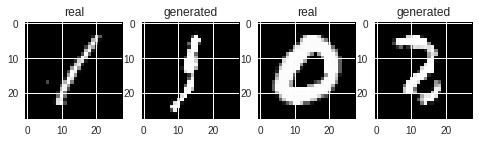


------------------------------------------------------------------------------
At step: 2100
G loss = 1.6110331
D loss = 0.3642468


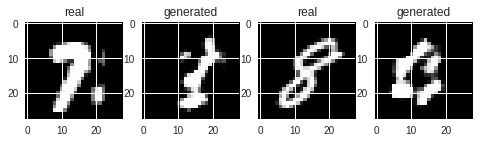


------------------------------------------------------------------------------
At step: 2200
G loss = 1.0765362
D loss = 0.40112963


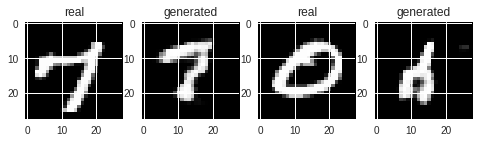


------------------------------------------------------------------------------
At step: 2300
G loss = 0.93015504
D loss = 0.48197478


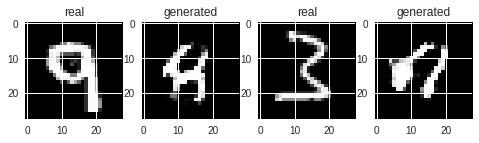


------------------------------------------------------------------------------
At step: 2400
G loss = 2.2694688
D loss = 0.490749


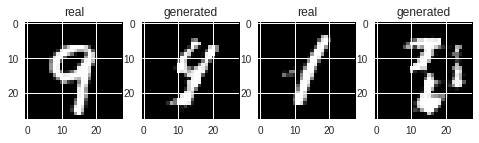


------------------------------------------------------------------------------
At step: 2500
G loss = 1.4752913
D loss = 0.42868537


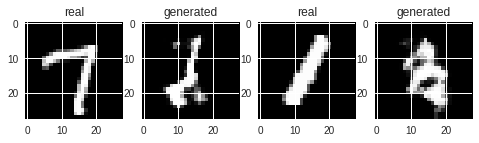


------------------------------------------------------------------------------
At step: 2600
G loss = 1.3664237
D loss = 0.44553536


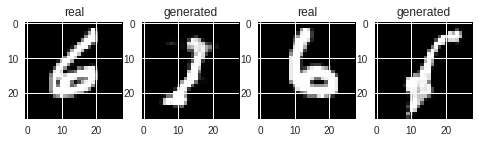


------------------------------------------------------------------------------
At step: 2700
G loss = 1.7964967
D loss = 0.38592407


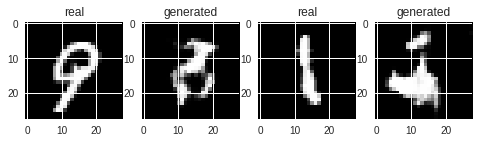


------------------------------------------------------------------------------
At step: 2800
G loss = 0.87078476
D loss = 0.49947524


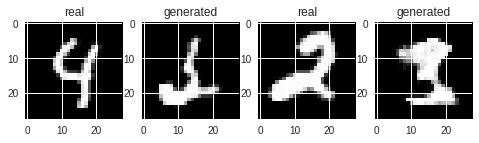


------------------------------------------------------------------------------
At step: 2900
G loss = 1.224996
D loss = 0.43399996


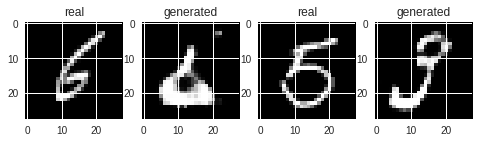


------------------------------------------------------------------------------
At step: 3000
G loss = 1.1367818
D loss = 0.45250648


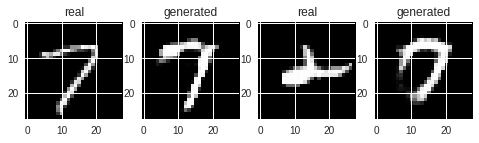


------------------------------------------------------------------------------
At step: 3100
G loss = 1.2886362
D loss = 0.43698522


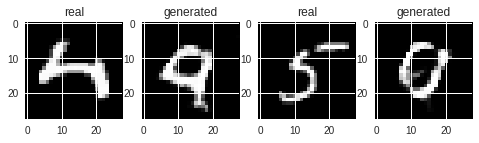


------------------------------------------------------------------------------
At step: 3200
G loss = 1.1407418
D loss = 0.45059097


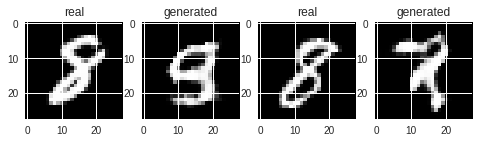


------------------------------------------------------------------------------
At step: 3300
G loss = 1.4389397
D loss = 0.4629864


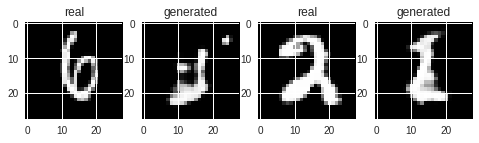


------------------------------------------------------------------------------
At step: 3400
G loss = 1.2024747
D loss = 0.4317667


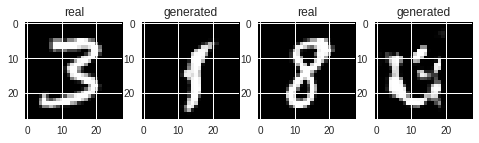


------------------------------------------------------------------------------
At step: 3500
G loss = 0.9038441
D loss = 0.4883753


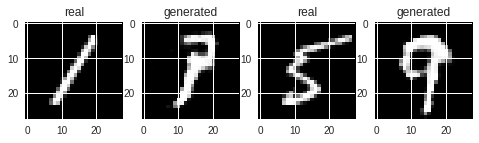


------------------------------------------------------------------------------
At step: 3600
G loss = 1.1744946
D loss = 0.46202832


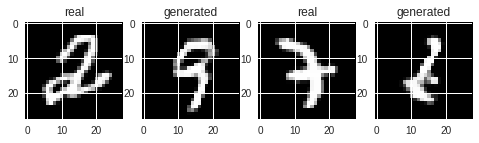


------------------------------------------------------------------------------
At step: 3700
G loss = 1.1336215
D loss = 0.48498756


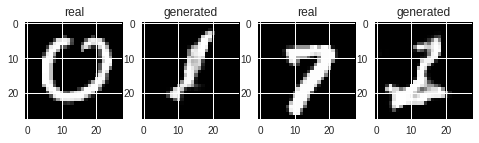


------------------------------------------------------------------------------
At step: 3800
G loss = 1.1656507
D loss = 0.46653342


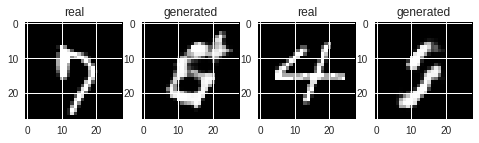


------------------------------------------------------------------------------
At step: 3900
G loss = 0.9916079
D loss = 0.47742754


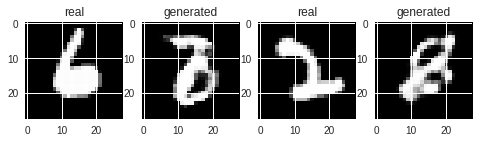


------------------------------------------------------------------------------
At step: 4000
G loss = 1.0171809
D loss = 0.4703405


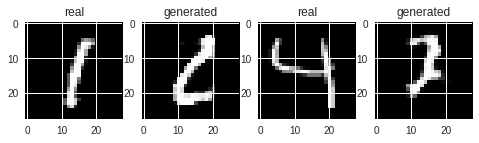


------------------------------------------------------------------------------
At step: 4100
G loss = 0.97884226
D loss = 0.5375846


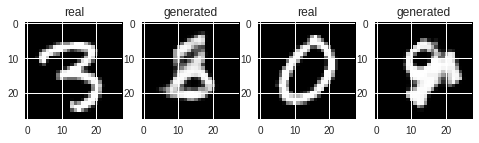


------------------------------------------------------------------------------
At step: 4200
G loss = 1.1470596
D loss = 0.5184834


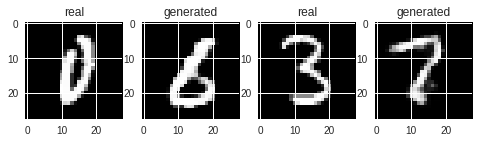


------------------------------------------------------------------------------
At step: 4300
G loss = 1.1089587
D loss = 0.5180231


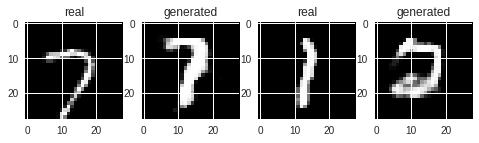


------------------------------------------------------------------------------
At step: 4400
G loss = 1.6949136
D loss = 0.550183


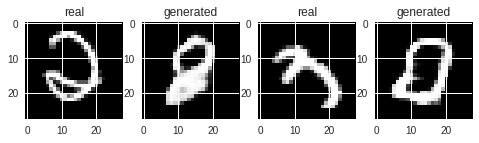


------------------------------------------------------------------------------
At step: 4500
G loss = 0.96847016
D loss = 0.50106514


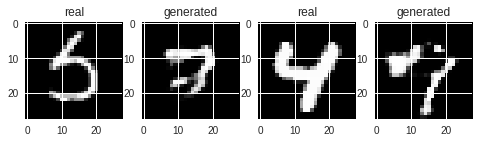


------------------------------------------------------------------------------
At step: 4600
G loss = 1.0688894
D loss = 0.5003242


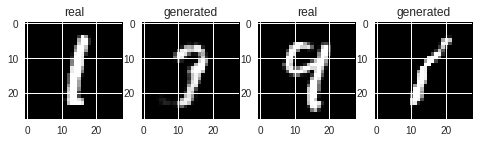


------------------------------------------------------------------------------
At step: 4700
G loss = 0.72896683
D loss = 0.56495297


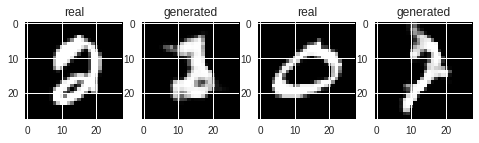


------------------------------------------------------------------------------
At step: 4800
G loss = 1.087467
D loss = 0.5049767


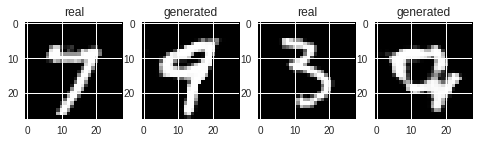


------------------------------------------------------------------------------
At step: 4900
G loss = 0.9543283
D loss = 0.5113356


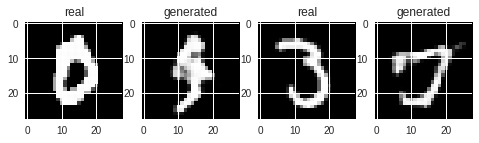


------------------------------------------------------------------------------
At step: 5000
G loss = 0.98201144
D loss = 0.4987558


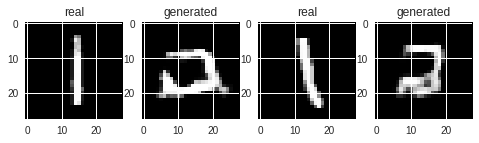


------------------------------------------------------------------------------
At step: 5100
G loss = 1.1316526
D loss = 0.5107023


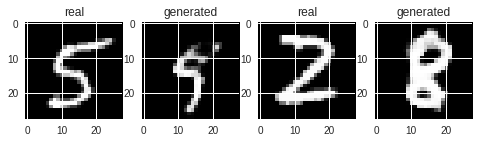


------------------------------------------------------------------------------
At step: 5200
G loss = 1.3156
D loss = 0.50634396


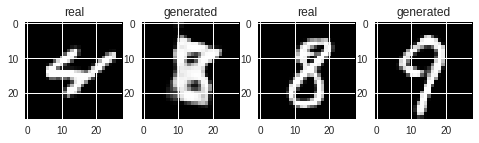


------------------------------------------------------------------------------
At step: 5300
G loss = 1.4175262
D loss = 0.5171941


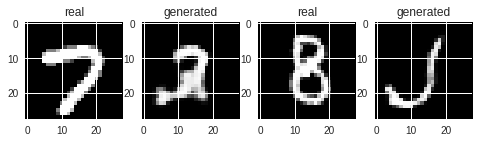


------------------------------------------------------------------------------
At step: 5400
G loss = 1.4821492
D loss = 0.48821872


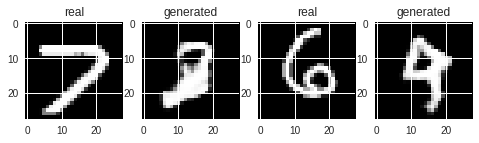


------------------------------------------------------------------------------
At step: 5500
G loss = 1.5319855
D loss = 0.4791695


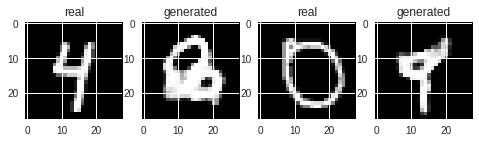


------------------------------------------------------------------------------
At step: 5600
G loss = 0.8910003
D loss = 0.5370248


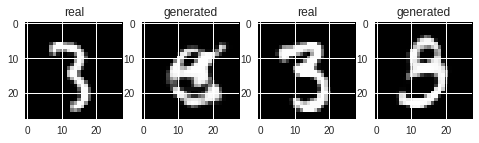


------------------------------------------------------------------------------
At step: 5700
G loss = 0.8119317
D loss = 0.5169315


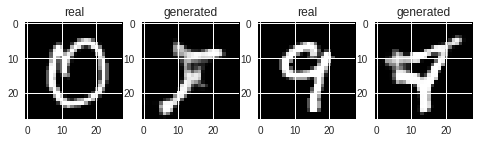


------------------------------------------------------------------------------
At step: 5800
G loss = 0.9623576
D loss = 0.523106


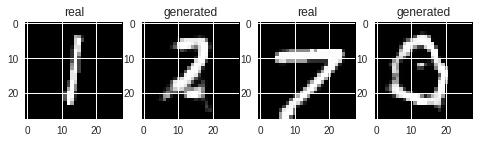


------------------------------------------------------------------------------
At step: 5900
G loss = 1.0178456
D loss = 0.5014206


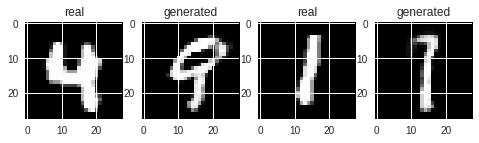


------------------------------------------------------------------------------
At step: 6000
G loss = 1.1155865
D loss = 0.4571712


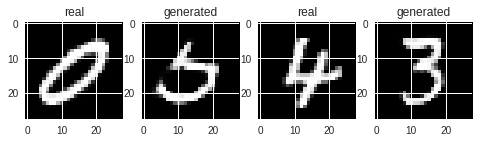


------------------------------------------------------------------------------
At step: 6100
G loss = 0.87578464
D loss = 0.5188393


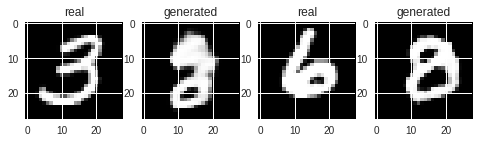


------------------------------------------------------------------------------
At step: 6200
G loss = 1.2323873
D loss = 0.5171167


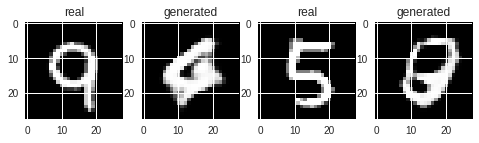


------------------------------------------------------------------------------
At step: 6300
G loss = 0.9632247
D loss = 0.49168873


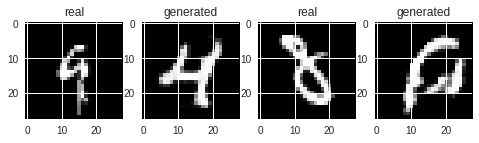


------------------------------------------------------------------------------
At step: 6400
G loss = 1.4584026
D loss = 0.5558543


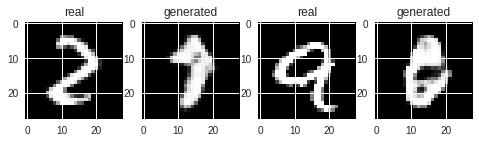


------------------------------------------------------------------------------
At step: 6500
G loss = 1.030009
D loss = 0.4925704


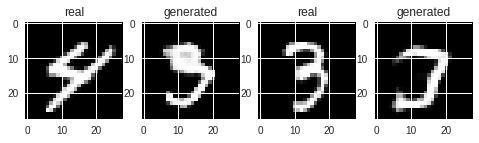


------------------------------------------------------------------------------
At step: 6600
G loss = 0.8886734
D loss = 0.5215515


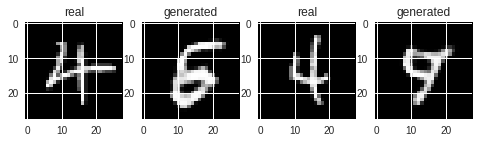


------------------------------------------------------------------------------
At step: 6700
G loss = 0.75528425
D loss = 0.5439352


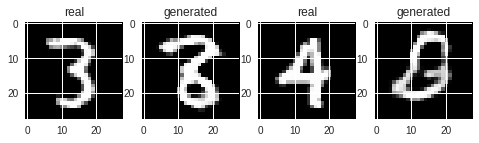


------------------------------------------------------------------------------
At step: 6800
G loss = 1.1634963
D loss = 0.4753458


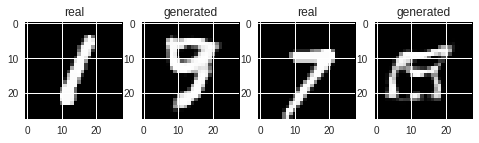


------------------------------------------------------------------------------
At step: 6900
G loss = 1.1472421
D loss = 0.50585556


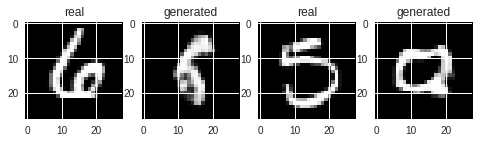


------------------------------------------------------------------------------
At step: 7000
G loss = 1.1461953
D loss = 0.5048298


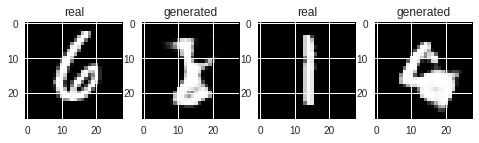


------------------------------------------------------------------------------
At step: 7100
G loss = 1.0667868
D loss = 0.5028607


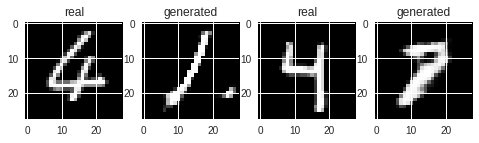


------------------------------------------------------------------------------
At step: 7200
G loss = 1.4084191
D loss = 0.47668362


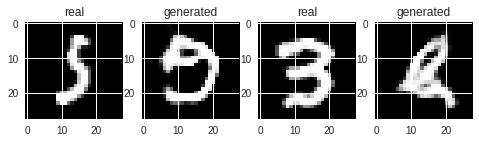


------------------------------------------------------------------------------
At step: 7300
G loss = 1.3481445
D loss = 0.4811907


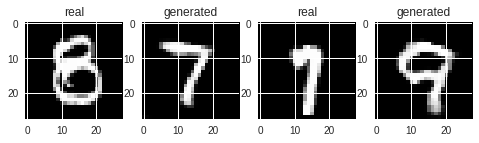


------------------------------------------------------------------------------
At step: 7400
G loss = 0.7859536
D loss = 0.5193882


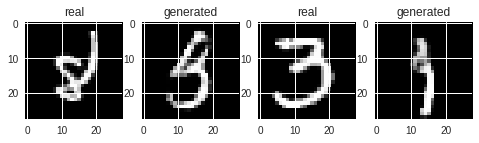


------------------------------------------------------------------------------
At step: 7500
G loss = 1.0128853
D loss = 0.44657183


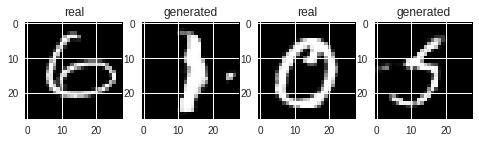


------------------------------------------------------------------------------
At step: 7600
G loss = 1.693464
D loss = 0.5518469


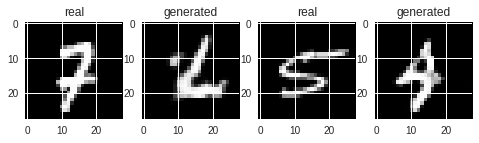


------------------------------------------------------------------------------
At step: 7700
G loss = 1.1419697
D loss = 0.5172591


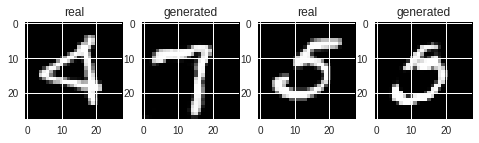


------------------------------------------------------------------------------
At step: 7800
G loss = 0.7277311
D loss = 0.5425254


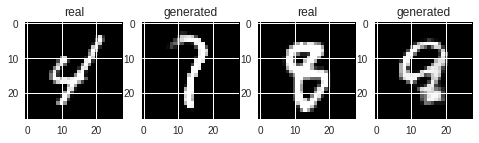


------------------------------------------------------------------------------
At step: 7900
G loss = 1.286866
D loss = 0.5120009


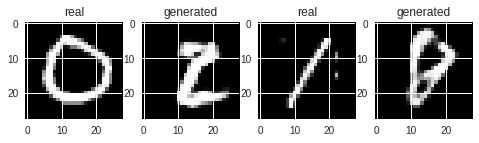


------------------------------------------------------------------------------
At step: 8000
G loss = 1.4093368
D loss = 0.49987617


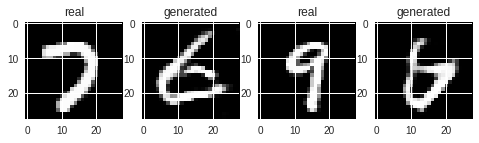


------------------------------------------------------------------------------
At step: 8100
G loss = 1.1706307
D loss = 0.49902493


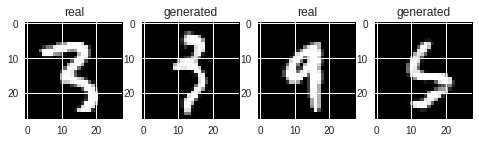


------------------------------------------------------------------------------
At step: 8200
G loss = 0.9431612
D loss = 0.49482304


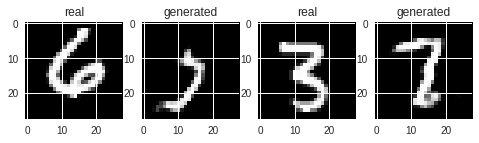


------------------------------------------------------------------------------
At step: 8300
G loss = 1.5388119
D loss = 0.47505835


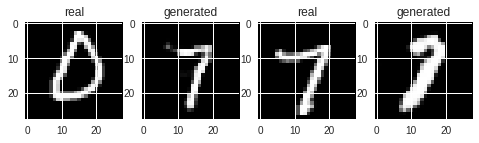


------------------------------------------------------------------------------
At step: 8400
G loss = 1.125355
D loss = 0.48852462


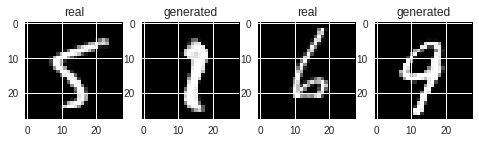


------------------------------------------------------------------------------
At step: 8500
G loss = 1.0985422
D loss = 0.48371625


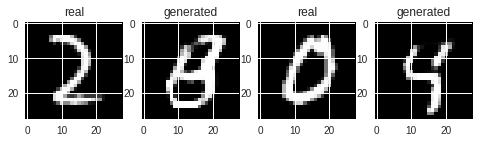


------------------------------------------------------------------------------
At step: 8600
G loss = 1.3575878
D loss = 0.47244254


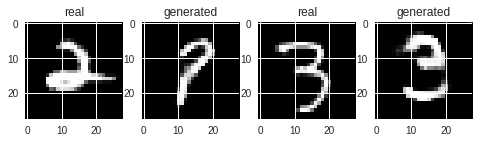


------------------------------------------------------------------------------
At step: 8700
G loss = 1.1398535
D loss = 0.5101194


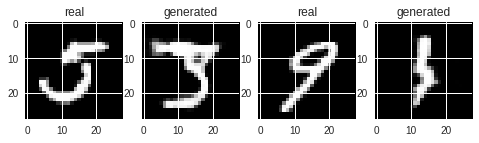


------------------------------------------------------------------------------
At step: 8800
G loss = 1.1080374
D loss = 0.47337383


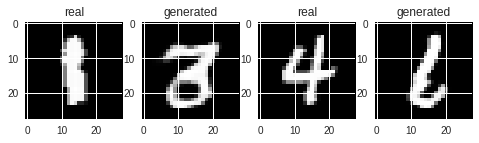


------------------------------------------------------------------------------
At step: 8900
G loss = 0.81884253
D loss = 0.53900385


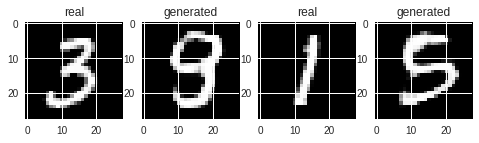


------------------------------------------------------------------------------
At step: 9000
G loss = 1.0774792
D loss = 0.5028472


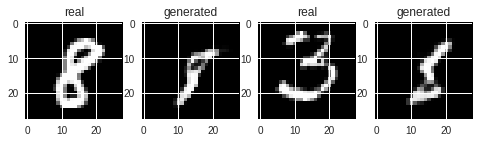


------------------------------------------------------------------------------
At step: 9100
G loss = 1.6469282
D loss = 0.5214494


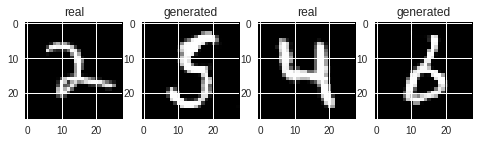


------------------------------------------------------------------------------
At step: 9200
G loss = 1.4248972
D loss = 0.45860094


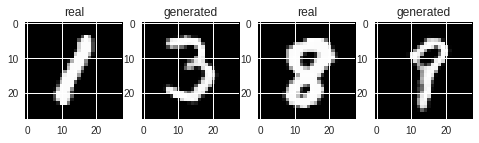


------------------------------------------------------------------------------
At step: 9300
G loss = 0.8800071
D loss = 0.50343984


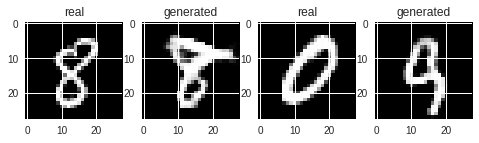


------------------------------------------------------------------------------
At step: 9400
G loss = 0.9595625
D loss = 0.5185765


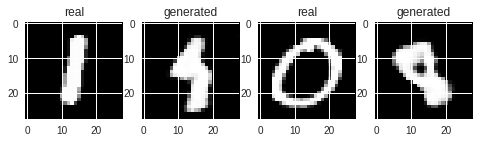


------------------------------------------------------------------------------
At step: 9500
G loss = 1.0212948
D loss = 0.5376713


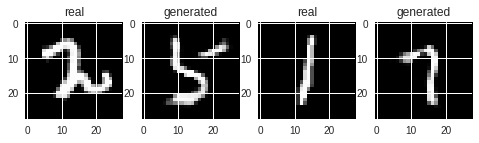


------------------------------------------------------------------------------
At step: 9600
G loss = 0.8698274
D loss = 0.49910071


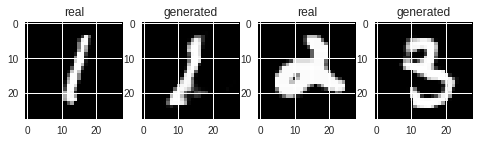


------------------------------------------------------------------------------
At step: 9700
G loss = 1.2073781
D loss = 0.4895437


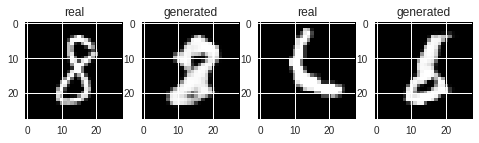


------------------------------------------------------------------------------
At step: 9800
G loss = 0.92054164
D loss = 0.5117582


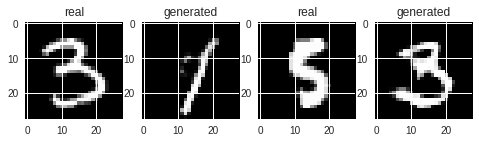


------------------------------------------------------------------------------
At step: 9900
G loss = 1.5160612
D loss = 0.53656614


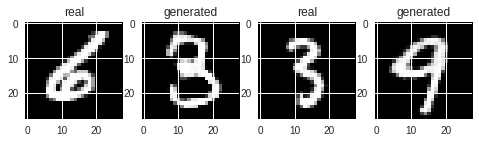


------------------------------------------------------------------------------
At step: 10000
G loss = 1.0419164
D loss = 0.4598068


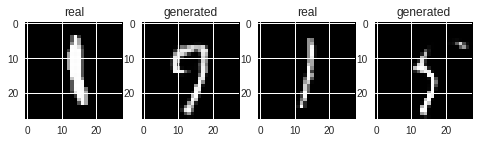


------------------------------------------------------------------------------
At step: 10100
G loss = 0.7450599
D loss = 0.5424648


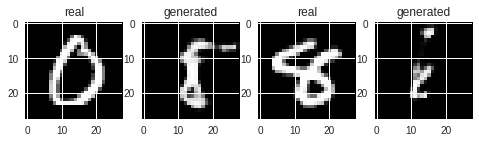


------------------------------------------------------------------------------
At step: 10200
G loss = 1.3457295
D loss = 0.48554367


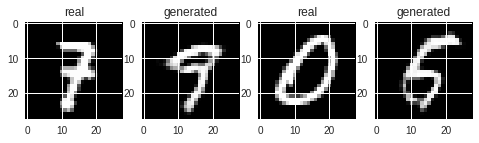


------------------------------------------------------------------------------
At step: 10300
G loss = 1.1335869
D loss = 0.49385118


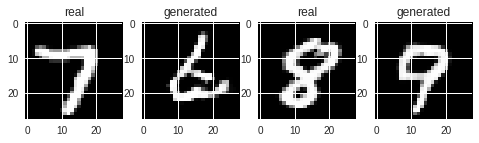


------------------------------------------------------------------------------
At step: 10400
G loss = 1.0067233
D loss = 0.4687043


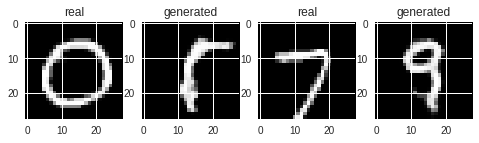


------------------------------------------------------------------------------
At step: 10500
G loss = 0.84237635
D loss = 0.54026705


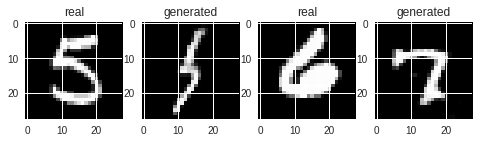


------------------------------------------------------------------------------
At step: 10600
G loss = 1.0082872
D loss = 0.5042014


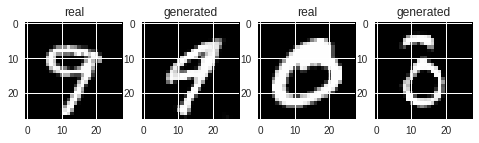


------------------------------------------------------------------------------
At step: 10700
G loss = 1.2026448
D loss = 0.4617363


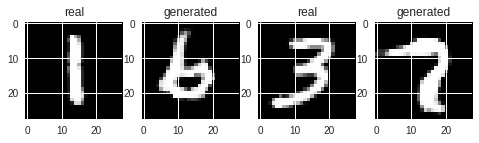


------------------------------------------------------------------------------
At step: 10800
G loss = 1.4445232
D loss = 0.47101507


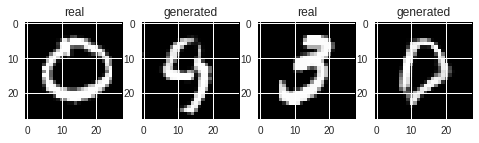


------------------------------------------------------------------------------
At step: 10900
G loss = 1.4047221
D loss = 0.5202214


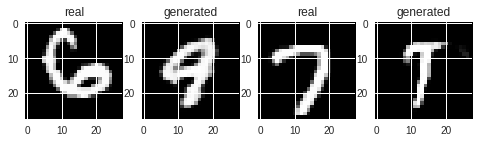


------------------------------------------------------------------------------
At step: 11000
G loss = 0.832631
D loss = 0.49810758


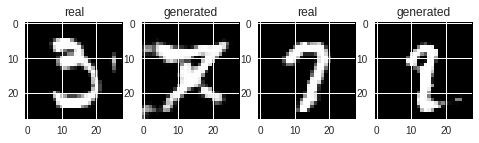


------------------------------------------------------------------------------
At step: 11100
G loss = 1.1836717
D loss = 0.4608118


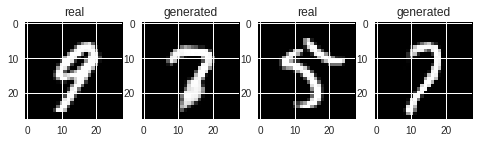


------------------------------------------------------------------------------
At step: 11200
G loss = 1.223406
D loss = 0.45649427


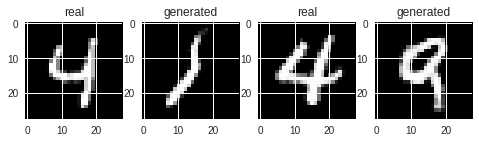


------------------------------------------------------------------------------
At step: 11300
G loss = 0.90280974
D loss = 0.5226833


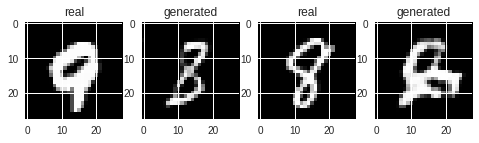


------------------------------------------------------------------------------
At step: 11400
G loss = 1.3477821
D loss = 0.51385045


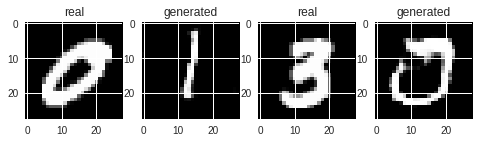


------------------------------------------------------------------------------
At step: 11500
G loss = 1.6793807
D loss = 0.49683726


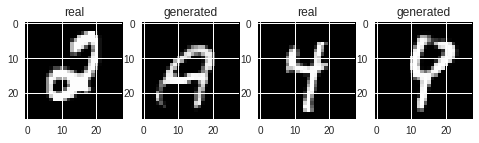


------------------------------------------------------------------------------
At step: 11600
G loss = 0.89982307
D loss = 0.49762395


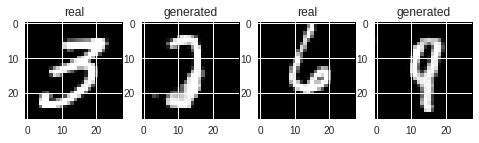


------------------------------------------------------------------------------
At step: 11700
G loss = 1.2466414
D loss = 0.50341636


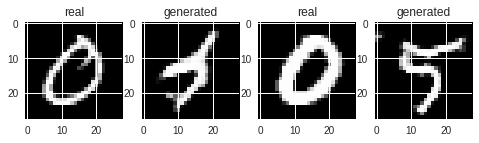


------------------------------------------------------------------------------
At step: 11800
G loss = 1.9102865
D loss = 0.56339353


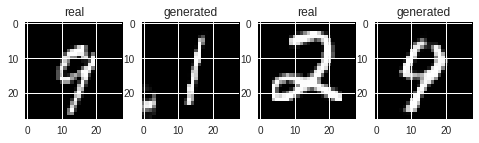


------------------------------------------------------------------------------
At step: 11900
G loss = 1.1759269
D loss = 0.50595134


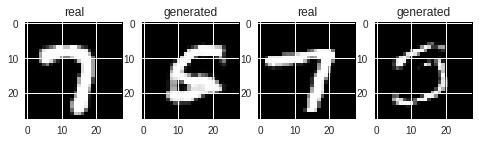


------------------------------------------------------------------------------
At step: 12000
G loss = 1.1731484
D loss = 0.49886948


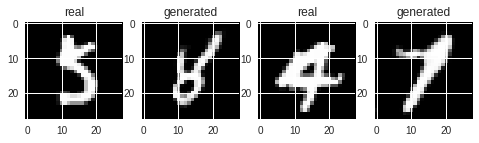


------------------------------------------------------------------------------
At step: 12100
G loss = 0.89149356
D loss = 0.52488905


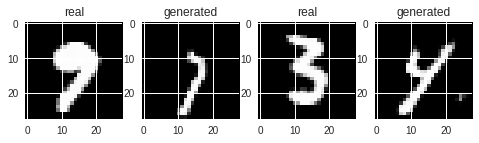


------------------------------------------------------------------------------
At step: 12200
G loss = 0.961318
D loss = 0.47835368


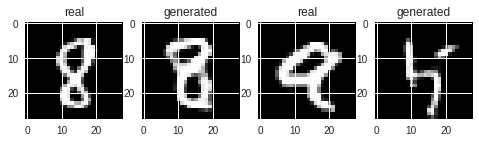


------------------------------------------------------------------------------
At step: 12300
G loss = 1.2034631
D loss = 0.5039043


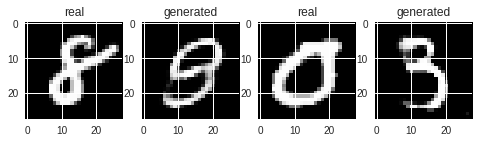


------------------------------------------------------------------------------
At step: 12400
G loss = 1.266307
D loss = 0.4715475


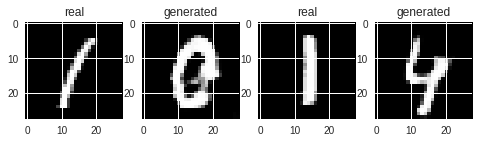


------------------------------------------------------------------------------
At step: 12500
G loss = 1.2412839
D loss = 0.4568153


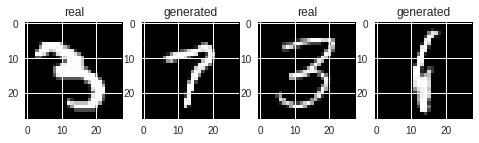


------------------------------------------------------------------------------
At step: 12600
G loss = 0.78945255
D loss = 0.5616117


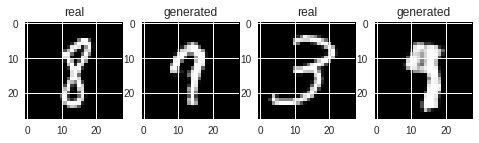


------------------------------------------------------------------------------
At step: 12700
G loss = 1.6452775
D loss = 0.48898745


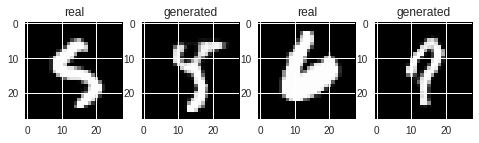


------------------------------------------------------------------------------
At step: 12800
G loss = 1.0915498
D loss = 0.45194298


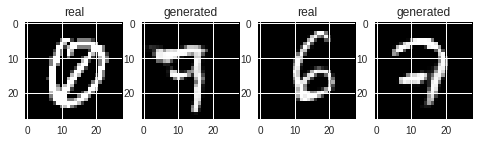


------------------------------------------------------------------------------
At step: 12900
G loss = 0.8696625
D loss = 0.51963025


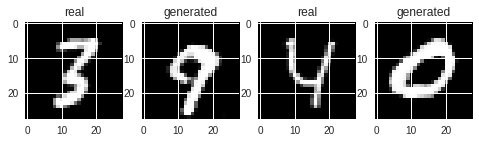


------------------------------------------------------------------------------
At step: 13000
G loss = 1.2519287
D loss = 0.4746765


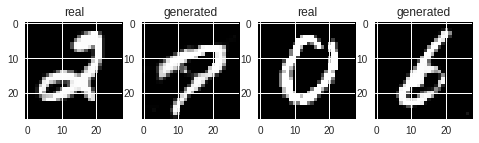


------------------------------------------------------------------------------
At step: 13100
G loss = 1.4130567
D loss = 0.4921012


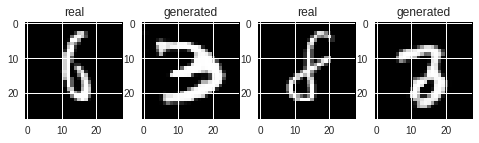


------------------------------------------------------------------------------
At step: 13200
G loss = 0.959002
D loss = 0.5002434


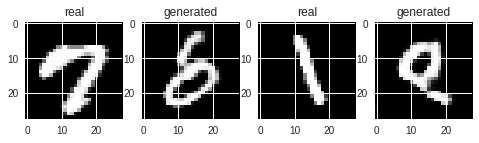


------------------------------------------------------------------------------
At step: 13300
G loss = 0.8739854
D loss = 0.5502361


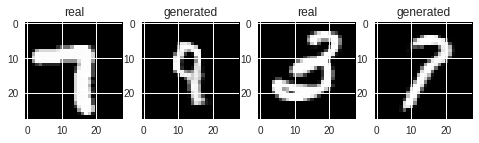


------------------------------------------------------------------------------
At step: 13400
G loss = 1.5654647
D loss = 0.49235752


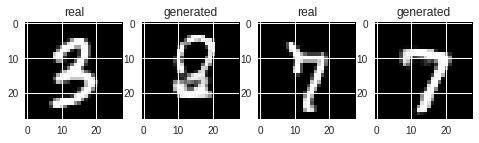


------------------------------------------------------------------------------
At step: 13500
G loss = 1.061466
D loss = 0.51309973


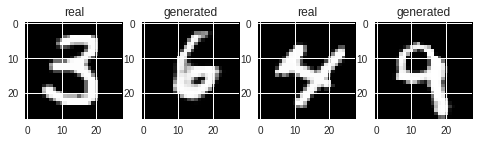


------------------------------------------------------------------------------
At step: 13600
G loss = 1.3746502
D loss = 0.4904381


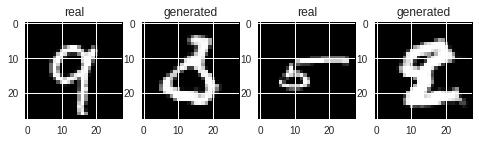


------------------------------------------------------------------------------
At step: 13700
G loss = 1.5679075
D loss = 0.52933455


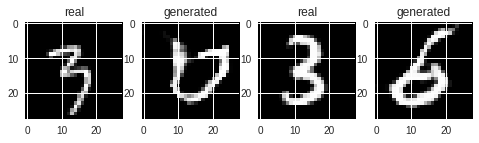


------------------------------------------------------------------------------
At step: 13800
G loss = 1.2824956
D loss = 0.48915625


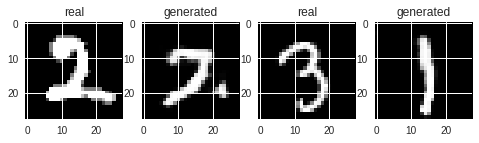


------------------------------------------------------------------------------
At step: 13900
G loss = 1.7469687
D loss = 0.49734324


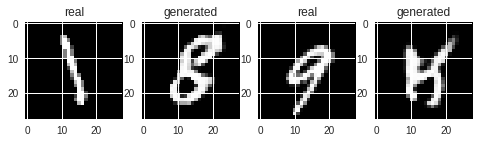


------------------------------------------------------------------------------
At step: 14000
G loss = 1.5942478
D loss = 0.53280115


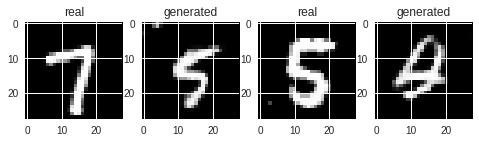


------------------------------------------------------------------------------
At step: 14100
G loss = 0.78134567
D loss = 0.5194517


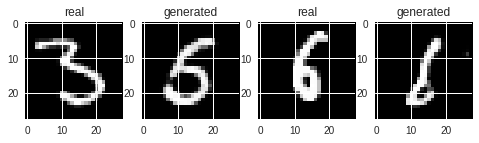


------------------------------------------------------------------------------
At step: 14200
G loss = 1.0309184
D loss = 0.47301298


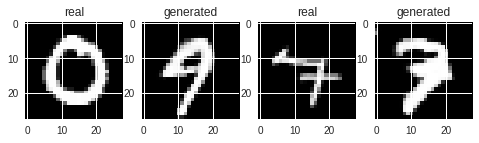


------------------------------------------------------------------------------
At step: 14300
G loss = 1.2603981
D loss = 0.46742183


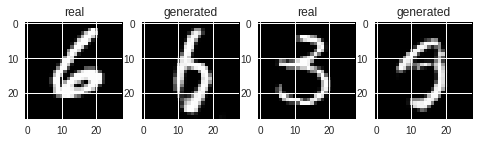


------------------------------------------------------------------------------
At step: 14400
G loss = 1.2144685
D loss = 0.4572373


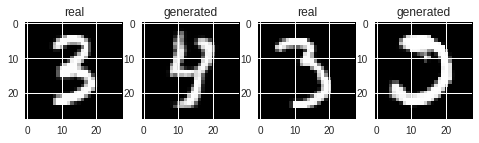


------------------------------------------------------------------------------
At step: 14500
G loss = 1.2309226
D loss = 0.4814154


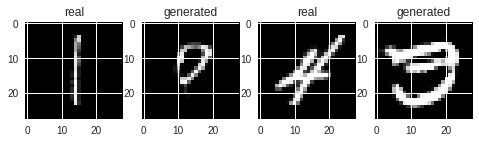


------------------------------------------------------------------------------
At step: 14600
G loss = 1.3777312
D loss = 0.45379066


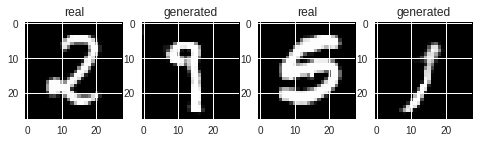


------------------------------------------------------------------------------
At step: 14700
G loss = 1.8683081
D loss = 0.5477431


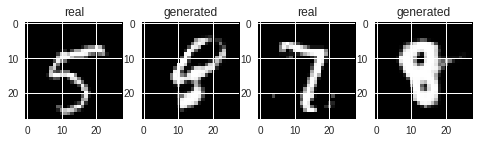


------------------------------------------------------------------------------
At step: 14800
G loss = 1.2051451
D loss = 0.4748966


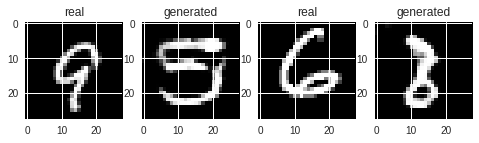


------------------------------------------------------------------------------
At step: 14900
G loss = 0.5343188
D loss = 0.65337884


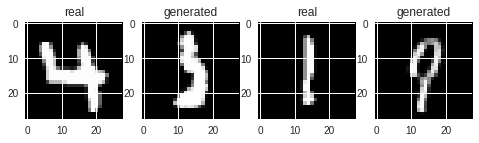


------------------------------------------------------------------------------
At step: 15000
G loss = 1.067811
D loss = 0.48637843


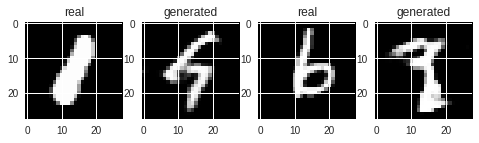


------------------------------------------------------------------------------
At step: 15100
G loss = 1.166734
D loss = 0.4931488


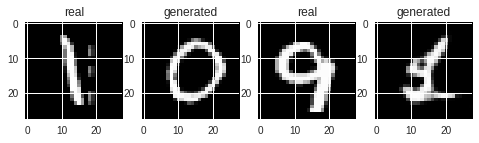


------------------------------------------------------------------------------
At step: 15200
G loss = 1.3988452
D loss = 0.5169926


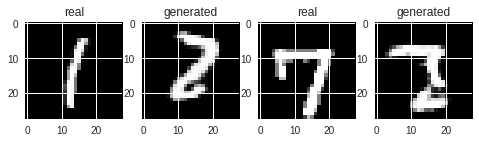


------------------------------------------------------------------------------
At step: 15300
G loss = 1.806818
D loss = 0.5060531


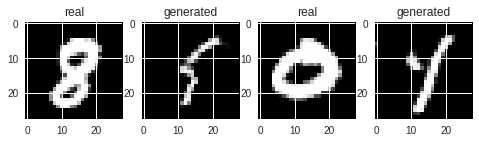


------------------------------------------------------------------------------
At step: 15400
G loss = 1.5711325
D loss = 0.54899836


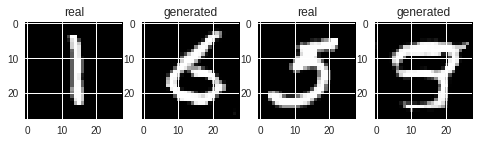


------------------------------------------------------------------------------
At step: 15500
G loss = 1.2087197
D loss = 0.5192367


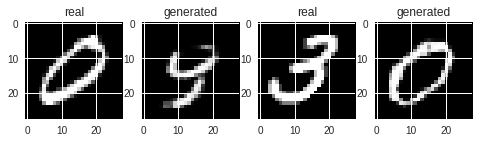


------------------------------------------------------------------------------
At step: 15600
G loss = 1.1841384
D loss = 0.5011736


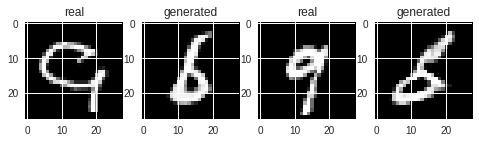


------------------------------------------------------------------------------
At step: 15700
G loss = 1.0397466
D loss = 0.52097356


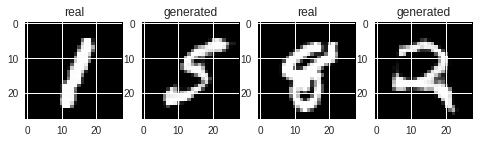


------------------------------------------------------------------------------
At step: 15800
G loss = 0.65459836
D loss = 0.59288293


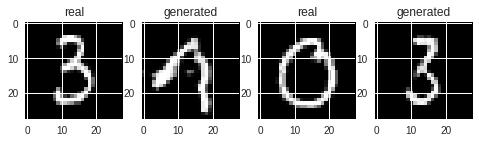


------------------------------------------------------------------------------
At step: 15900
G loss = 0.7775665
D loss = 0.56083304


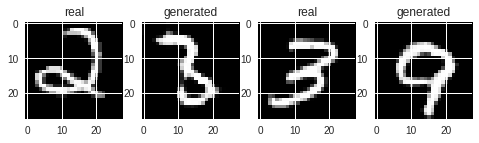


------------------------------------------------------------------------------
At step: 16000
G loss = 0.9899901
D loss = 0.49924877


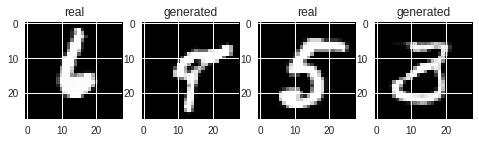


------------------------------------------------------------------------------
At step: 16100
G loss = 1.3703778
D loss = 0.48976493


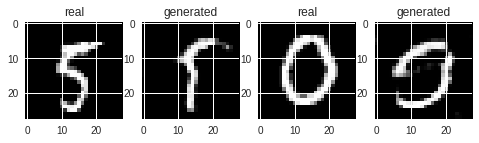


------------------------------------------------------------------------------
At step: 16200
G loss = 1.1463323
D loss = 0.46538615


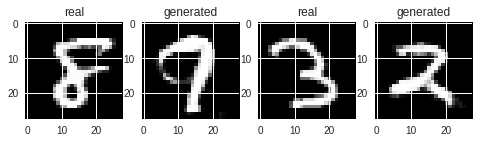


------------------------------------------------------------------------------
At step: 16300
G loss = 1.139705
D loss = 0.4555273


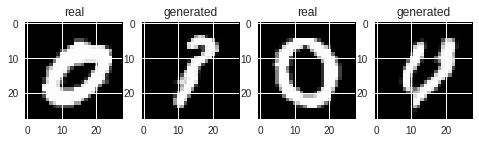


------------------------------------------------------------------------------
At step: 16400
G loss = 1.1176891
D loss = 0.50386363


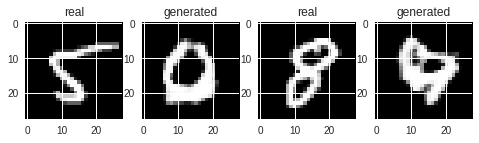


------------------------------------------------------------------------------
At step: 16500
G loss = 1.5546424
D loss = 0.48316205


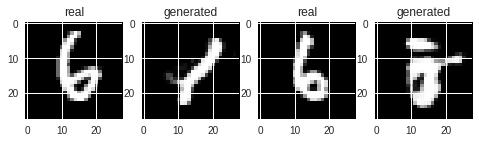


------------------------------------------------------------------------------
At step: 16600
G loss = 0.88487077
D loss = 0.526851


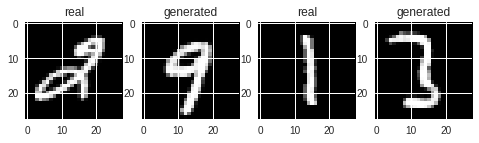


------------------------------------------------------------------------------
At step: 16700
G loss = 0.8292166
D loss = 0.52357465


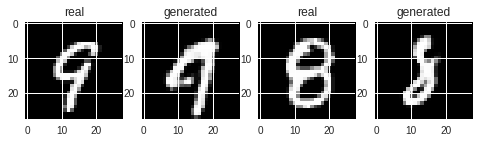


------------------------------------------------------------------------------
At step: 16800
G loss = 1.492141
D loss = 0.49853468


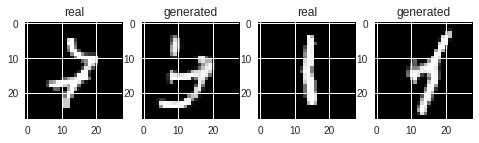


------------------------------------------------------------------------------
At step: 16900
G loss = 1.6281451
D loss = 0.5157467


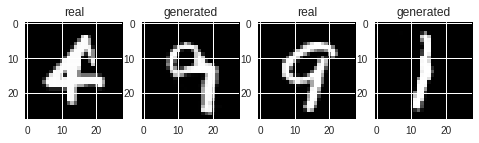


------------------------------------------------------------------------------
At step: 17000
G loss = 1.0835226
D loss = 0.50659215


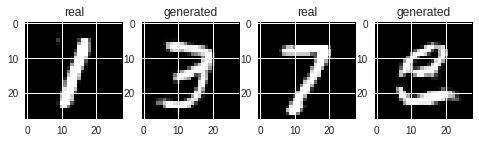


------------------------------------------------------------------------------
At step: 17100
G loss = 1.2418431
D loss = 0.48682404


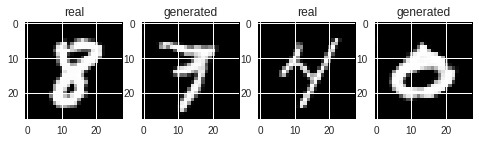


------------------------------------------------------------------------------
At step: 17200
G loss = 1.3328071
D loss = 0.46975437


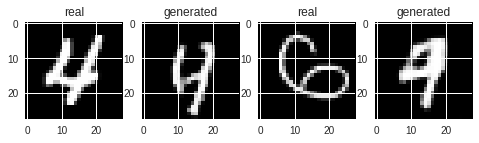


------------------------------------------------------------------------------
At step: 17300
G loss = 1.1568743
D loss = 0.441863


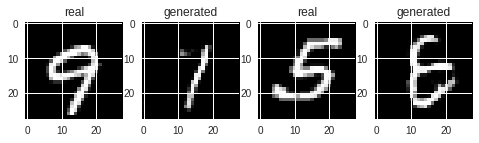


------------------------------------------------------------------------------
At step: 17400
G loss = 1.2647634
D loss = 0.4972064


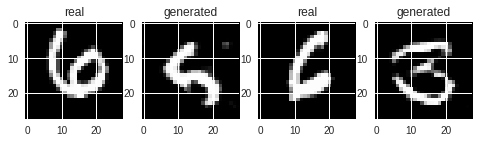


------------------------------------------------------------------------------
At step: 17500
G loss = 1.6129388
D loss = 0.49340343


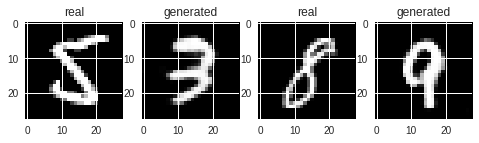


------------------------------------------------------------------------------
At step: 17600
G loss = 1.6029468
D loss = 0.453204


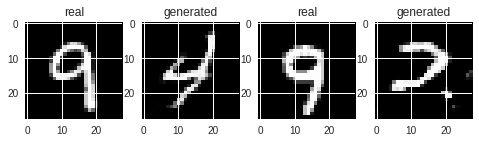


------------------------------------------------------------------------------
At step: 17700
G loss = 1.2370625
D loss = 0.48478562


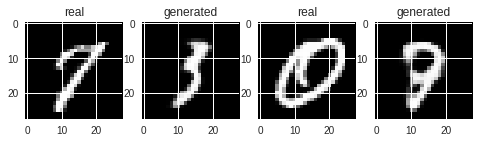


------------------------------------------------------------------------------
At step: 17800
G loss = 1.5915607
D loss = 0.50742435


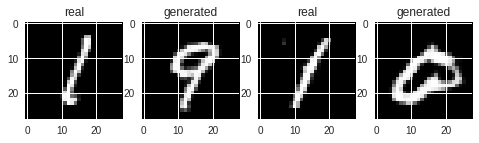


------------------------------------------------------------------------------
At step: 17900
G loss = 1.3504806
D loss = 0.51775753


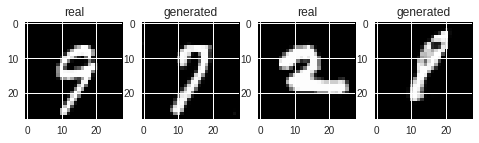


------------------------------------------------------------------------------
At step: 18000
G loss = 1.4191413
D loss = 0.45226866


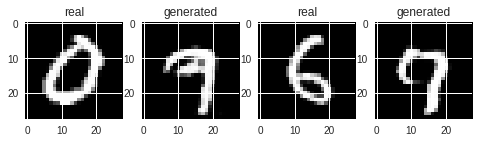


------------------------------------------------------------------------------
At step: 18100
G loss = 1.3611431
D loss = 0.43308026


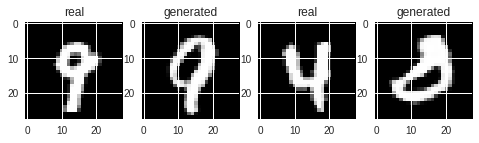


------------------------------------------------------------------------------
At step: 18200
G loss = 1.1699336
D loss = 0.48058572


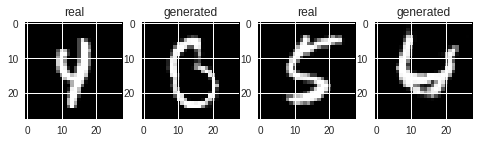


------------------------------------------------------------------------------
At step: 18300
G loss = 0.93956566
D loss = 0.48991734


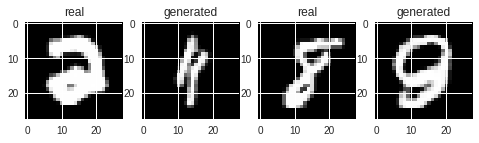


------------------------------------------------------------------------------
At step: 18400
G loss = 0.9774844
D loss = 0.5057682


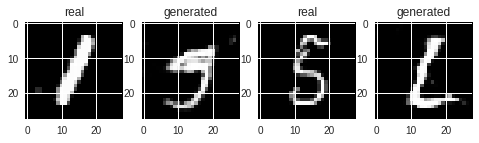


------------------------------------------------------------------------------
At step: 18500
G loss = 0.8721409
D loss = 0.52282333


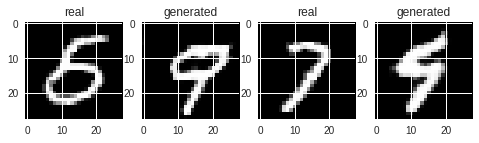


------------------------------------------------------------------------------
At step: 18600
G loss = 1.6111637
D loss = 0.45664233


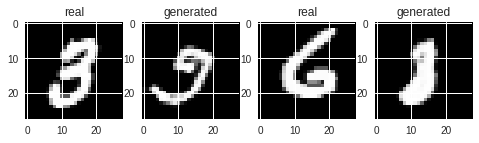


------------------------------------------------------------------------------
At step: 18700
G loss = 1.3309302
D loss = 0.51300436


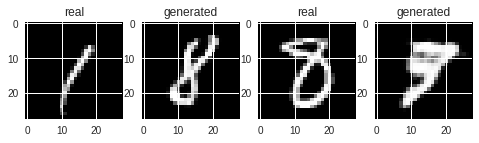

In [0]:
training() 

In [0]:
#run time!
z_dim = 100
LR = 0.0002
x_dim = 784
batch_size = 128
noise_var = 1.5
noise_steps = 5000

def training():
    with tf.Graph().as_default():
        sess = tf.Session()
        global_step = tf.get_variable('global_step', shape=[],dtype=tf.int32)
        
        noise = tf.train.polynomial_decay(noise_var, global_step,noise_steps,0.0,power=1.0)#linear decay to zero noise by step: noise_steps
        
        x = tf.placeholder(tf.float32, [batch_size, x_dim], 'real-images')
        
        z = tf.random_normal([batch_size, z_dim], mean=0, stddev=1.0)#Latent: Gaussian
        
        gen_x = gen(z, reuse=False)
        
        gen_x_n = gen_x + tf.random_normal([batch_size, x_dim], mean=0.0, stddev=noise)#adding noise
        x_n = x + tf.random_normal([batch_size, x_dim], mean=0.0, stddev=noise)
        
        d_fake = dis(gen_x_n, reuse=False)
        d_real = dis(x_n, reuse=True)
        
        g_train, g_loss = gen_train(d_fake, LR)
        d_train, d_loss = dis_train(d_fake, d_real, LR)
       
        initial_var = tf.global_variables_initializer()
        sess.run(initial_var)
        
        train = True
        step = 0
        
        while train == True:
            real_data = random_batch(train_images, batch_size)
            _g, _d = sess.run([g_train, d_train], feed_dict={x: real_data})
            
            if step % 100 == 0:
                loss_g, loss_d, gen_images, var_noise, gen_images_n, real_data_n = sess.run([g_loss, d_loss, gen_x, noise, gen_x_n, x_n], feed_dict={x: real_data})
                print()
                print('------------------------------------------------------------------------------')
                print('At step:', step, ', with variance of noise =', var_noise)
                print('G loss =', loss_g)
                print('D loss =', loss_d)
                print()
                print('Without Noise')
                plt.subplot(1, 4, 1)
                plt.title('real')
                plt.imshow(np.reshape(real_data[0], [28,28]), cmap='gray')
                
                plt.subplot(1, 4, 2)
                plt.title('generated')
                plt.imshow(np.reshape(gen_images[0], [28,28]), cmap='gray')
                
                plt.subplot(1, 4, 3)
                plt.title('real')
                plt.imshow(np.reshape(real_data[1], [28,28]), cmap='gray')
                
                plt.subplot(1, 4, 4)
                plt.title('generated')
                plt.imshow(np.reshape(gen_images[1], [28,28]), cmap='gray')
                plt.show()
                
                if step <= noise_steps:
                    print()
                    print('With Noise')
                    plt.subplot(1, 4, 1)
                    plt.title('real')
                    plt.imshow(np.reshape(real_data_n[0], [28,28]), cmap='gray')

                    plt.subplot(1, 4, 2)
                    plt.title('generated')
                    plt.imshow(np.reshape(gen_images_n[0], [28,28]), cmap='gray')

                    plt.subplot(1, 4, 3)
                    plt.title('real')
                    plt.imshow(np.reshape(real_data_n[1], [28,28]), cmap='gray')

                    plt.subplot(1, 4, 4)
                    plt.title('generated')
                    plt.imshow(np.reshape(gen_images_n[1], [28,28]), cmap='gray')
                    plt.show()                
                
            step += 1
                


------------------------------------------------------------------------------
At step: 0 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.6564862
D loss = 0.70336133

Without Noise


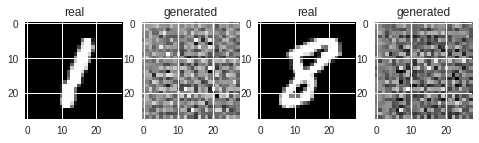


With Noise


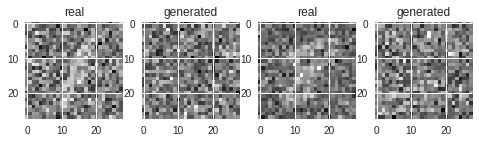


------------------------------------------------------------------------------
At step: 100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 2.0982718
D loss = 0.17704883

Without Noise


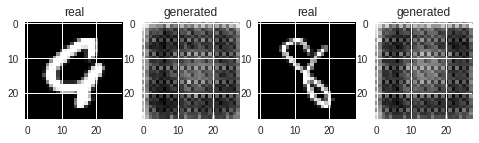


With Noise


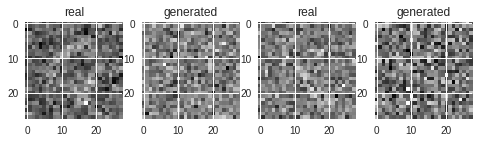


------------------------------------------------------------------------------
At step: 200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2159102
D loss = 0.4984304

Without Noise


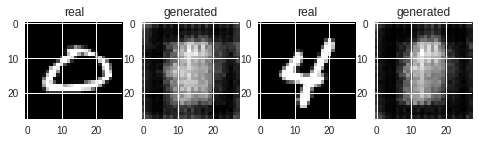


With Noise


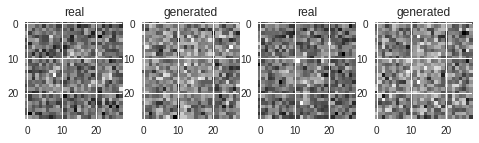


------------------------------------------------------------------------------
At step: 300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.99328655
D loss = 0.49000466

Without Noise


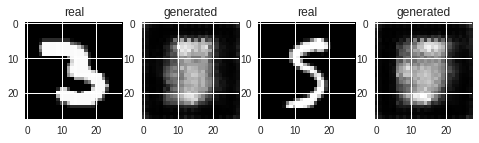


With Noise


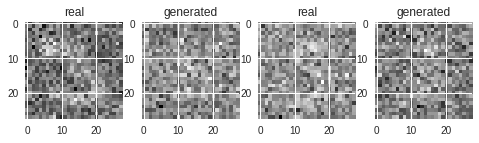


------------------------------------------------------------------------------
At step: 400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.615643
D loss = 0.2630064

Without Noise


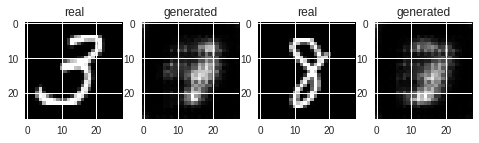


With Noise


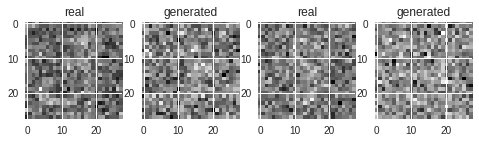


------------------------------------------------------------------------------
At step: 500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.931307
D loss = 0.27480155

Without Noise


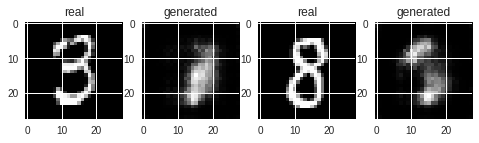


With Noise


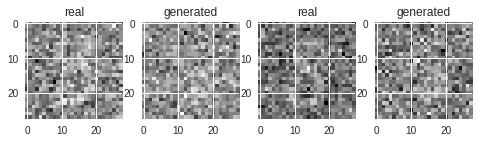


------------------------------------------------------------------------------
At step: 600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.6146243
D loss = 0.33440548

Without Noise


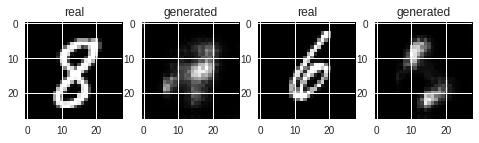


With Noise


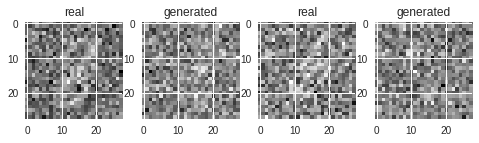


------------------------------------------------------------------------------
At step: 700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.3821001
D loss = 0.4962383

Without Noise


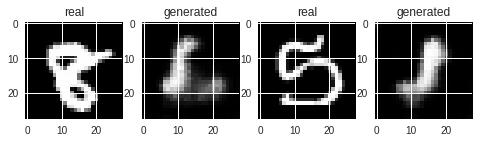


With Noise


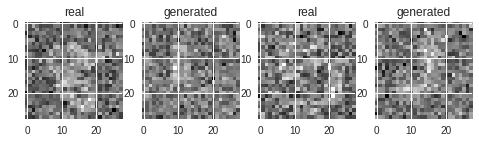


------------------------------------------------------------------------------
At step: 800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.118964
D loss = 0.5604353

Without Noise


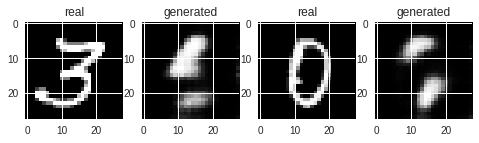


With Noise


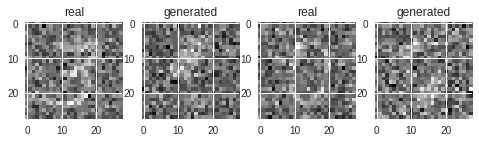


------------------------------------------------------------------------------
At step: 900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0781476
D loss = 0.5018191

Without Noise


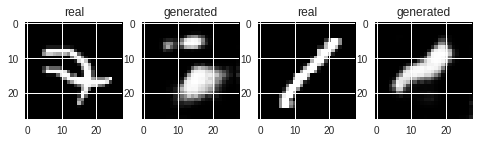


With Noise


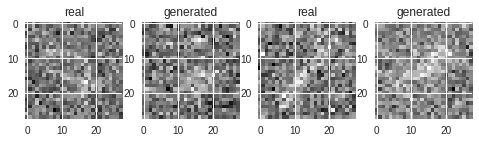


------------------------------------------------------------------------------
At step: 1000 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2806368
D loss = 0.45037144

Without Noise


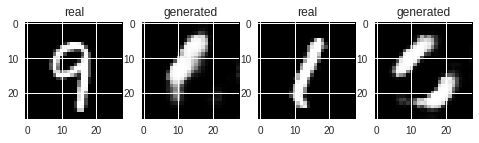


With Noise


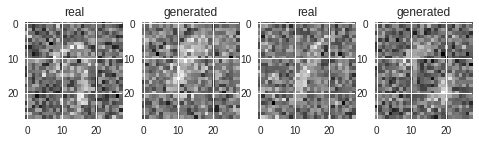


------------------------------------------------------------------------------
At step: 1100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2436093
D loss = 0.41495916

Without Noise


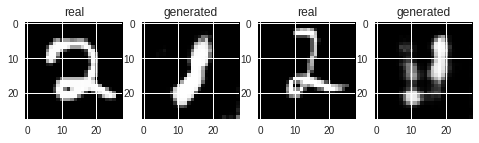


With Noise


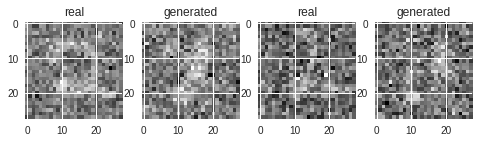


------------------------------------------------------------------------------
At step: 1200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0252647
D loss = 0.45567325

Without Noise


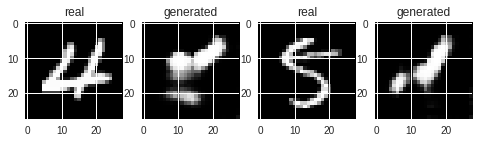


With Noise


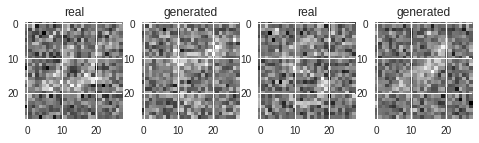


------------------------------------------------------------------------------
At step: 1300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0682927
D loss = 0.45778584

Without Noise


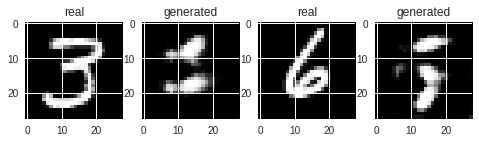


With Noise


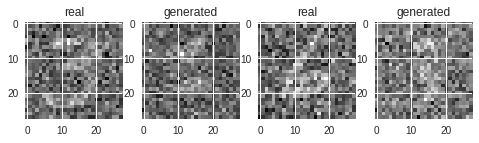


------------------------------------------------------------------------------
At step: 1400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.5699515
D loss = 0.3846972

Without Noise


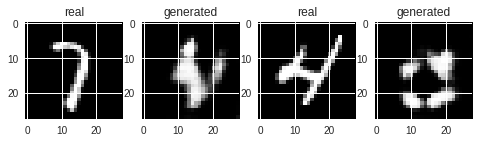


With Noise


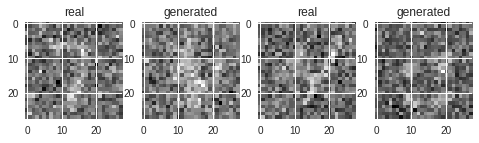


------------------------------------------------------------------------------
At step: 1500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.3689511
D loss = 0.4393159

Without Noise


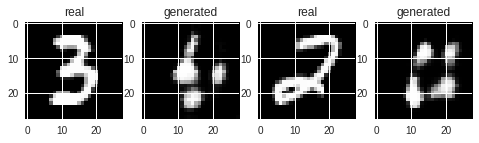


With Noise


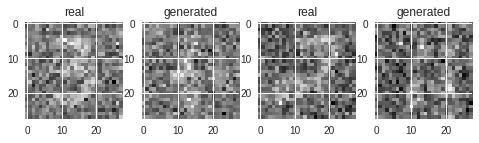


------------------------------------------------------------------------------
At step: 1600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1590276
D loss = 0.48627517

Without Noise


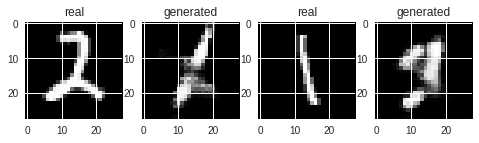


With Noise


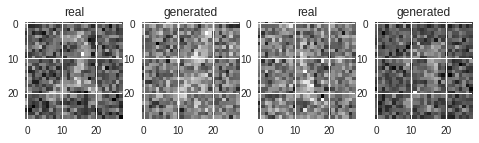


------------------------------------------------------------------------------
At step: 1700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.396678
D loss = 0.45747158

Without Noise


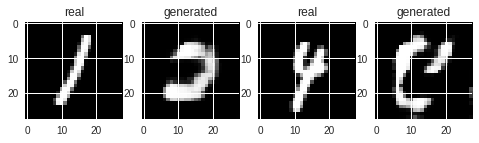


With Noise


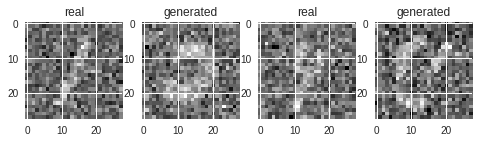


------------------------------------------------------------------------------
At step: 1800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.006595
D loss = 0.5018424

Without Noise


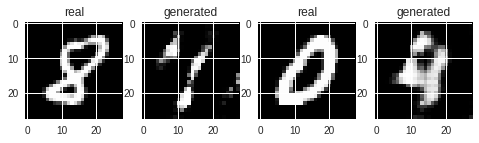


With Noise


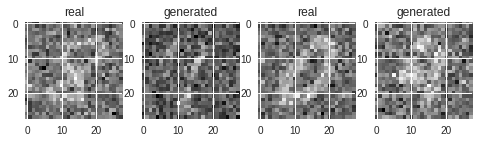


------------------------------------------------------------------------------
At step: 1900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.4401327
D loss = 0.47913256

Without Noise


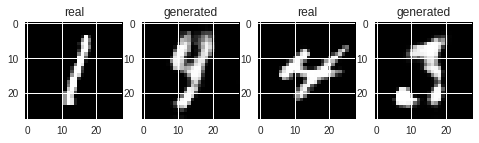


With Noise


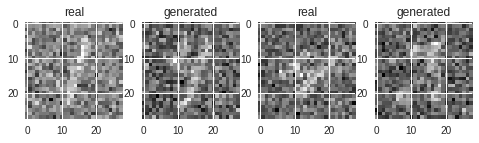


------------------------------------------------------------------------------
At step: 2000 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.138442
D loss = 0.49728665

Without Noise


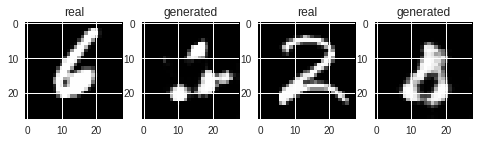


With Noise


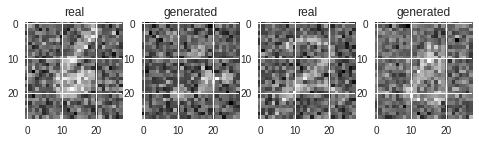


------------------------------------------------------------------------------
At step: 2100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2020061
D loss = 0.49833328

Without Noise


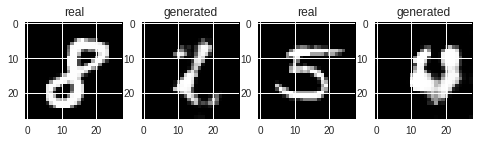


With Noise


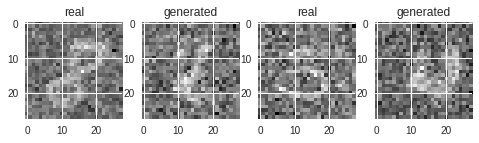


------------------------------------------------------------------------------
At step: 2200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.99752665
D loss = 0.54136467

Without Noise


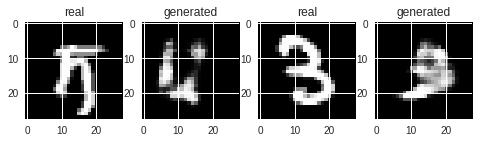


With Noise


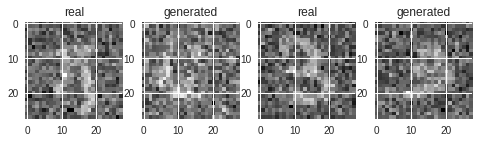


------------------------------------------------------------------------------
At step: 2300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0509543
D loss = 0.5326003

Without Noise


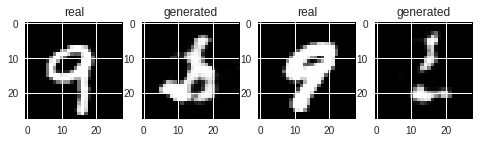


With Noise


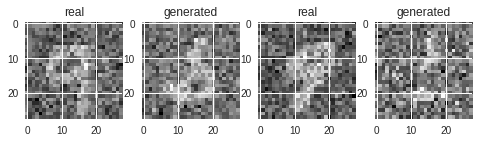


------------------------------------------------------------------------------
At step: 2400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1313106
D loss = 0.49265063

Without Noise


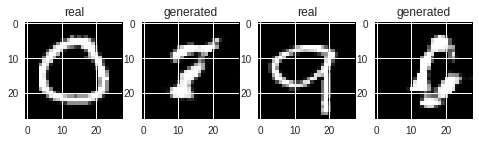


With Noise


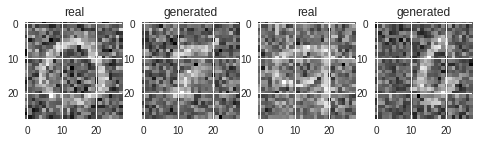


------------------------------------------------------------------------------
At step: 2500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0610648
D loss = 0.51231754

Without Noise


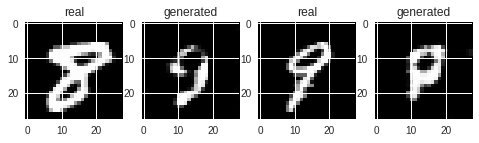


With Noise


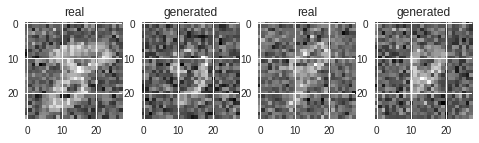


------------------------------------------------------------------------------
At step: 2600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2151945
D loss = 0.51866204

Without Noise


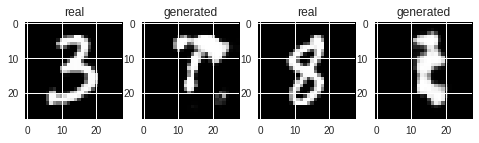


With Noise


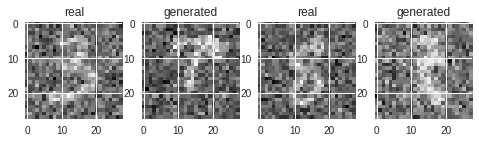


------------------------------------------------------------------------------
At step: 2700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0420512
D loss = 0.53145134

Without Noise


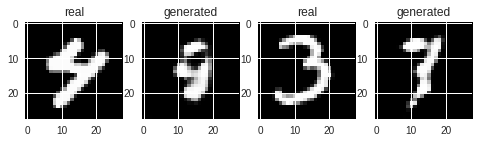


With Noise


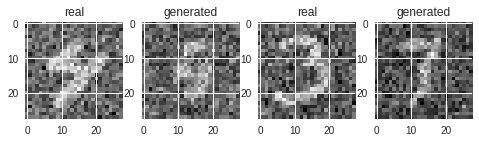


------------------------------------------------------------------------------
At step: 2800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1211008
D loss = 0.49921444

Without Noise


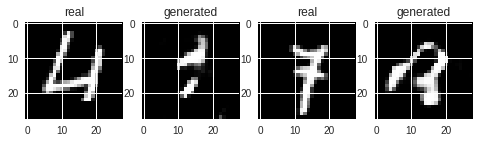


With Noise


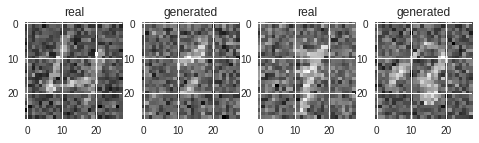


------------------------------------------------------------------------------
At step: 2900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0699971
D loss = 0.5069146

Without Noise


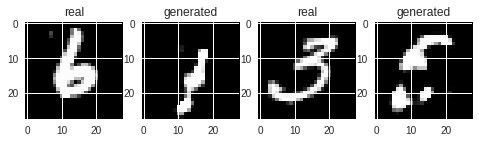


With Noise


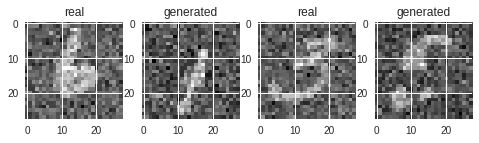


------------------------------------------------------------------------------
At step: 3000 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0702977
D loss = 0.48859352

Without Noise


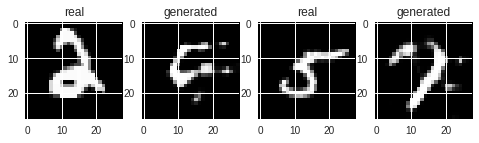


With Noise


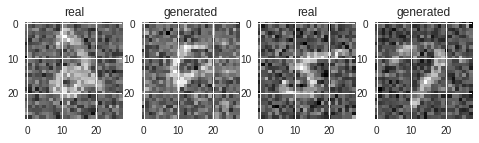


------------------------------------------------------------------------------
At step: 3100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.962638
D loss = 0.5040767

Without Noise


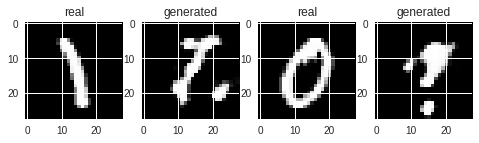


With Noise


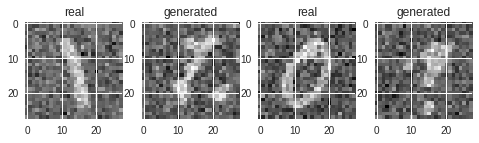


------------------------------------------------------------------------------
At step: 3200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1237009
D loss = 0.49301174

Without Noise


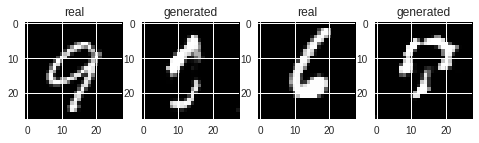


With Noise


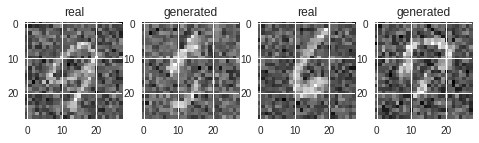


------------------------------------------------------------------------------
At step: 3300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0963701
D loss = 0.49590674

Without Noise


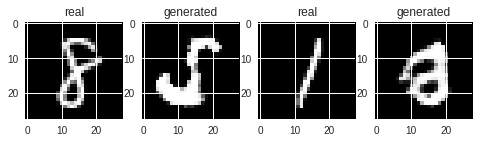


With Noise


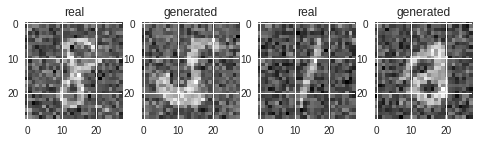


------------------------------------------------------------------------------
At step: 3400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0333018
D loss = 0.5149893

Without Noise


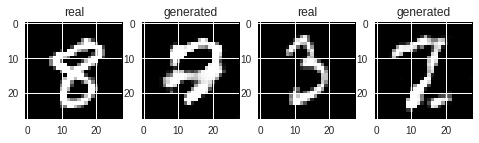


With Noise


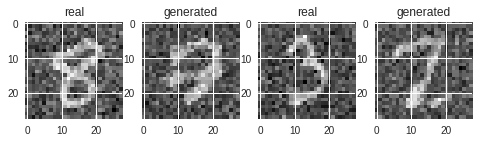


------------------------------------------------------------------------------
At step: 3500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2918489
D loss = 0.49315858

Without Noise


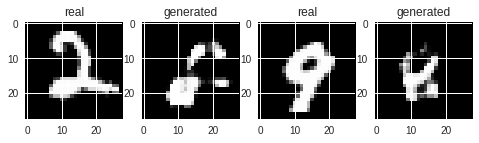


With Noise


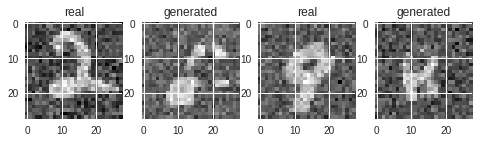


------------------------------------------------------------------------------
At step: 3600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0924493
D loss = 0.5576586

Without Noise


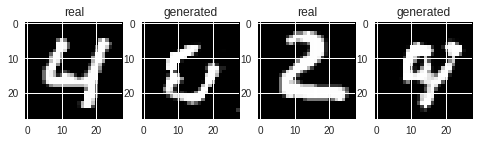


With Noise


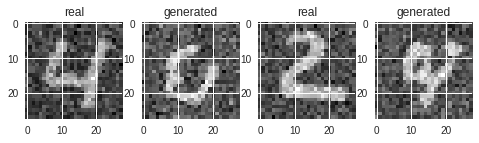


------------------------------------------------------------------------------
At step: 3700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1056912
D loss = 0.52042973

Without Noise


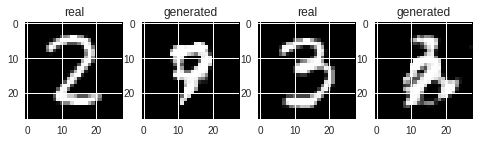


With Noise


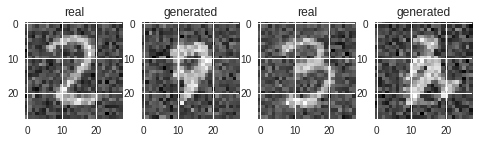


------------------------------------------------------------------------------
At step: 3800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1186492
D loss = 0.5284268

Without Noise


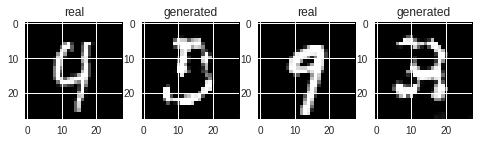


With Noise


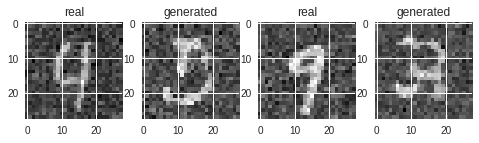


------------------------------------------------------------------------------
At step: 3900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.9446515
D loss = 0.5546908

Without Noise


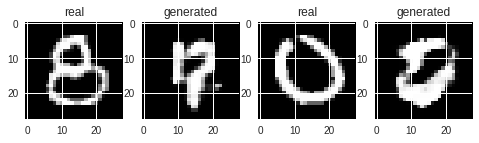


With Noise


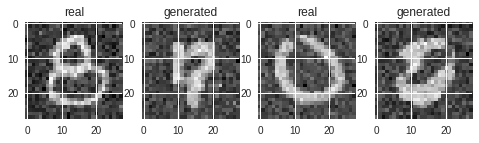


------------------------------------------------------------------------------
At step: 4000 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.159853
D loss = 0.5062616

Without Noise


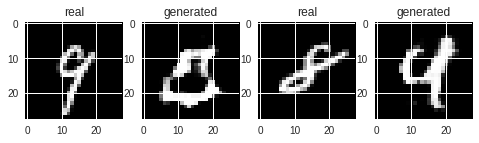


With Noise


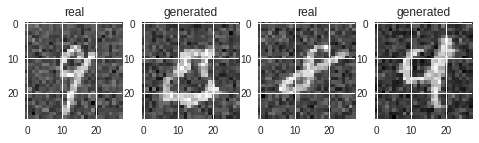


------------------------------------------------------------------------------
At step: 4100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1215303
D loss = 0.4768169

Without Noise


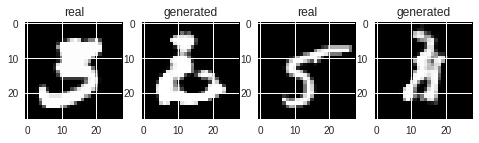


With Noise


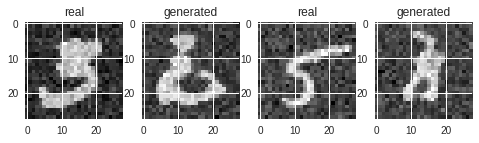


------------------------------------------------------------------------------
At step: 4200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.984534
D loss = 0.5273129

Without Noise


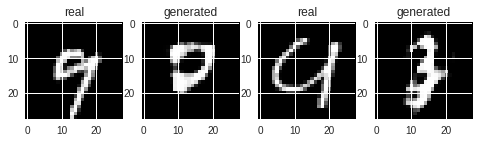


With Noise


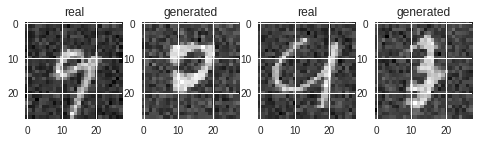


------------------------------------------------------------------------------
At step: 4300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.8605038
D loss = 0.5352186

Without Noise


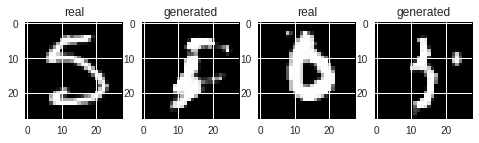


With Noise


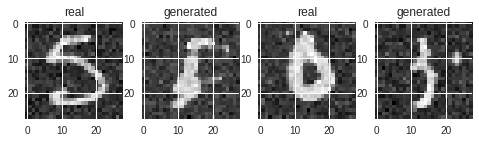


------------------------------------------------------------------------------
At step: 4400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0198252
D loss = 0.5215037

Without Noise


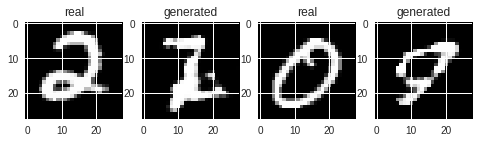


With Noise


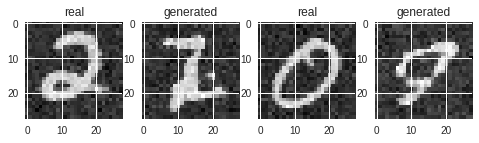


------------------------------------------------------------------------------
At step: 4500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.000591
D loss = 0.48250315

Without Noise


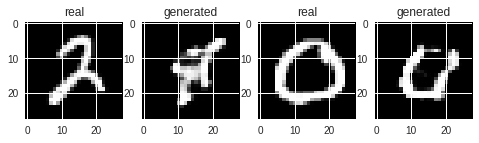


With Noise


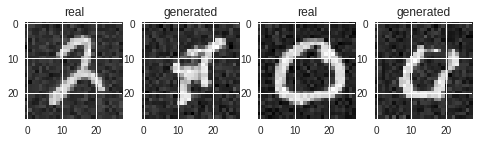


------------------------------------------------------------------------------
At step: 4600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2339957
D loss = 0.5203991

Without Noise


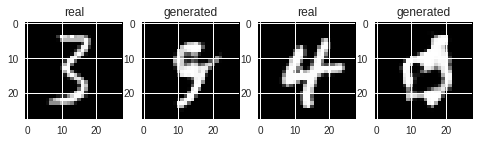


With Noise


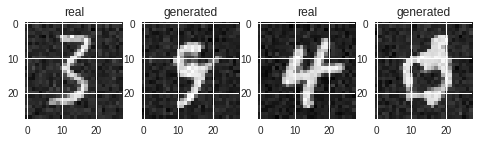


------------------------------------------------------------------------------
At step: 4700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.9119963
D loss = 0.5122501

Without Noise


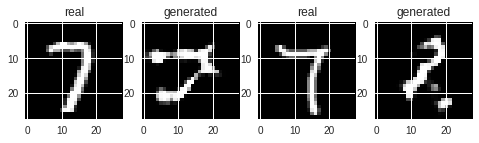


With Noise


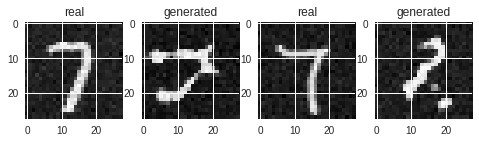


------------------------------------------------------------------------------
At step: 4800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0867424
D loss = 0.5354548

Without Noise


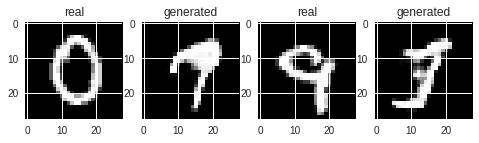


With Noise


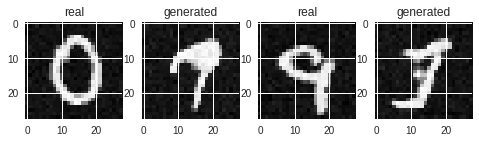


------------------------------------------------------------------------------
At step: 4900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0722909
D loss = 0.49036705

Without Noise


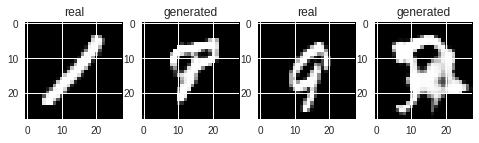


With Noise


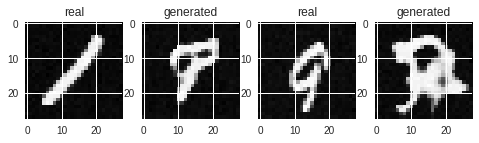


------------------------------------------------------------------------------
At step: 5000 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0168009
D loss = 0.49262768

Without Noise


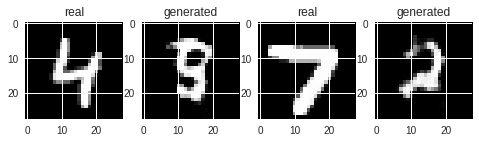


With Noise


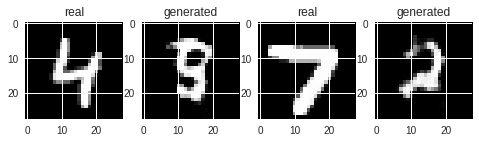


------------------------------------------------------------------------------
At step: 5100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0094693
D loss = 0.50476253

Without Noise


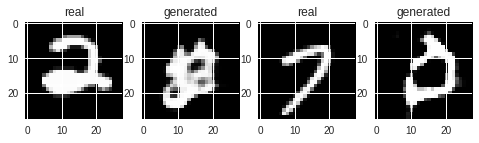


------------------------------------------------------------------------------
At step: 5200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.197567
D loss = 0.47733057

Without Noise


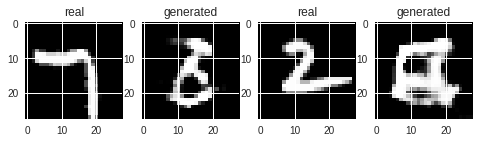


------------------------------------------------------------------------------
At step: 5300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.89188784
D loss = 0.53299594

Without Noise


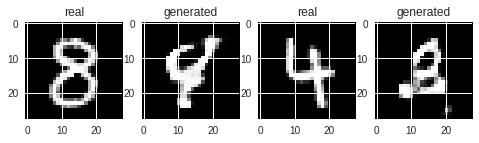


------------------------------------------------------------------------------
At step: 5400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2099438
D loss = 0.50037503

Without Noise


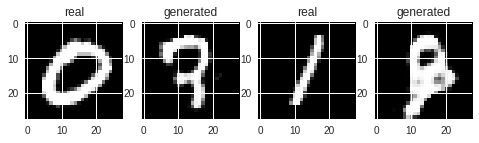


------------------------------------------------------------------------------
At step: 5500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1796095
D loss = 0.48167452

Without Noise


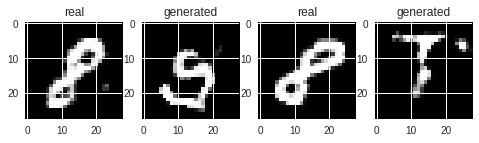


------------------------------------------------------------------------------
At step: 5600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.9924985
D loss = 0.4933503

Without Noise


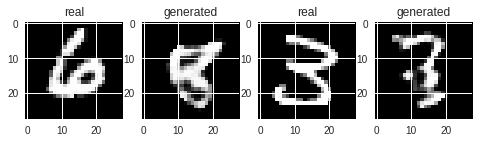


------------------------------------------------------------------------------
At step: 5700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0046722
D loss = 0.48507902

Without Noise


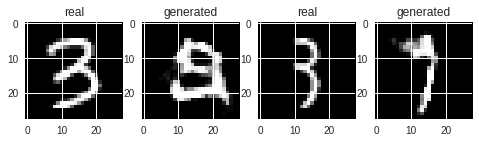


------------------------------------------------------------------------------
At step: 5800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.095382
D loss = 0.49275574

Without Noise


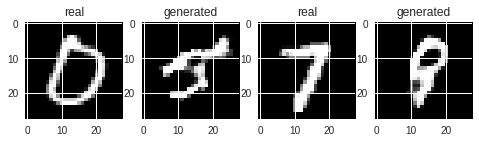


------------------------------------------------------------------------------
At step: 5900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.8927716
D loss = 0.53955853

Without Noise


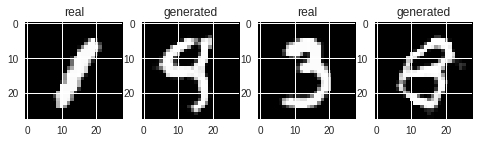


------------------------------------------------------------------------------
At step: 6000 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.96576154
D loss = 0.516922

Without Noise


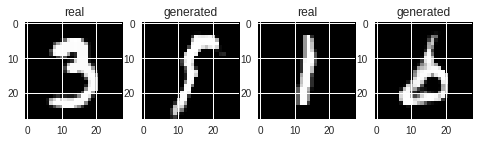


------------------------------------------------------------------------------
At step: 6100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1280279
D loss = 0.5272521

Without Noise


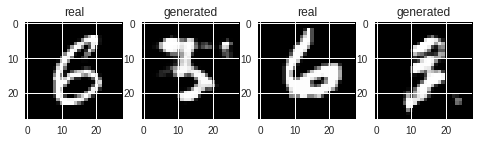


------------------------------------------------------------------------------
At step: 6200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.125311
D loss = 0.5317369

Without Noise


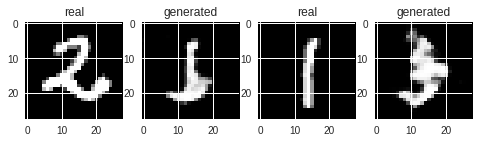


------------------------------------------------------------------------------
At step: 6300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1422036
D loss = 0.49462268

Without Noise


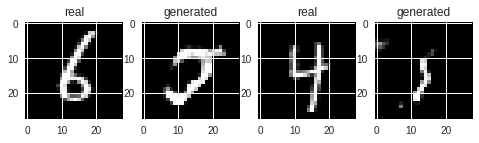


------------------------------------------------------------------------------
At step: 6400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.4632878
D loss = 0.5195597

Without Noise


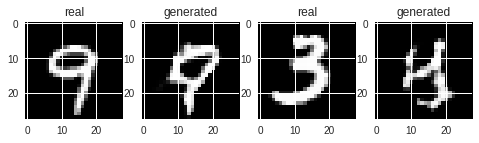


------------------------------------------------------------------------------
At step: 6500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1230369
D loss = 0.511949

Without Noise


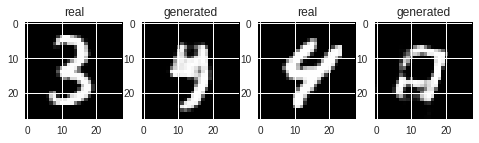


------------------------------------------------------------------------------
At step: 6600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1509607
D loss = 0.5308694

Without Noise


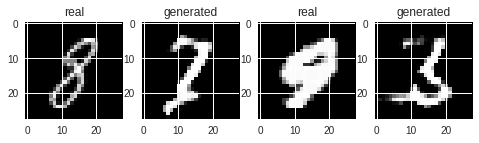


------------------------------------------------------------------------------
At step: 6700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.84975713
D loss = 0.53207034

Without Noise


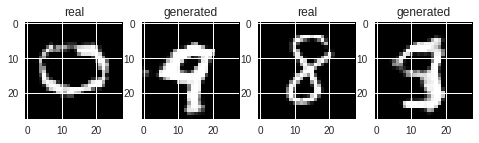


------------------------------------------------------------------------------
At step: 6800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.9611578
D loss = 0.53583646

Without Noise


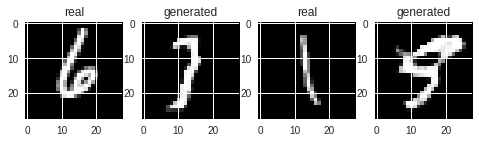


------------------------------------------------------------------------------
At step: 6900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.9977251
D loss = 0.52046543

Without Noise


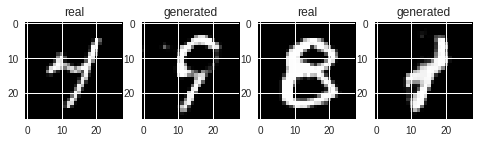


------------------------------------------------------------------------------
At step: 7000 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0500364
D loss = 0.51896966

Without Noise


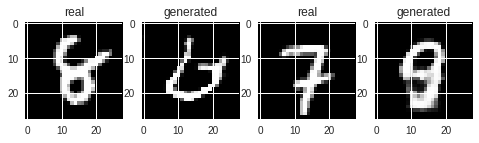


------------------------------------------------------------------------------
At step: 7100 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1258074
D loss = 0.5097245

Without Noise


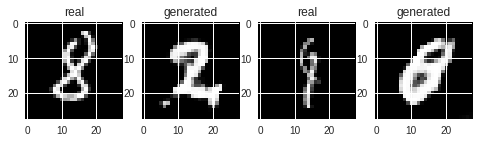


------------------------------------------------------------------------------
At step: 7200 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1732467
D loss = 0.5114993

Without Noise


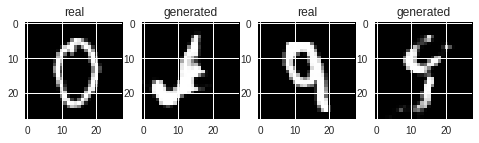


------------------------------------------------------------------------------
At step: 7300 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.2283504
D loss = 0.5678446

Without Noise


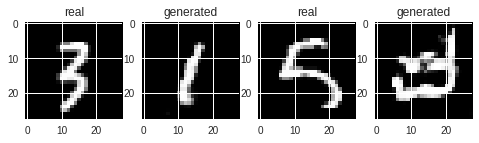


------------------------------------------------------------------------------
At step: 7400 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0607709
D loss = 0.5488644

Without Noise


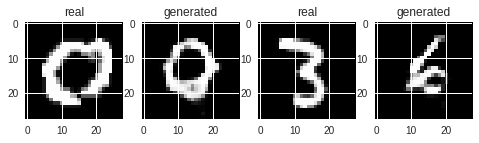


------------------------------------------------------------------------------
At step: 7500 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1364892
D loss = 0.5747328

Without Noise


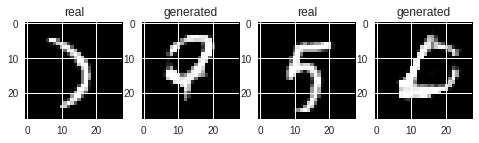


------------------------------------------------------------------------------
At step: 7600 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.1722987
D loss = 0.54493177

Without Noise


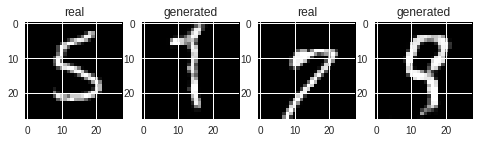


------------------------------------------------------------------------------
At step: 7700 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.93762857
D loss = 0.50942695

Without Noise


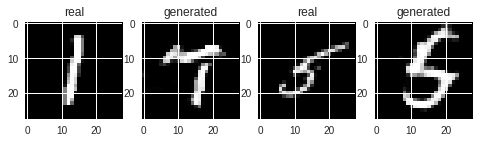


------------------------------------------------------------------------------
At step: 7800 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 1.0021415
D loss = 0.5428479

Without Noise


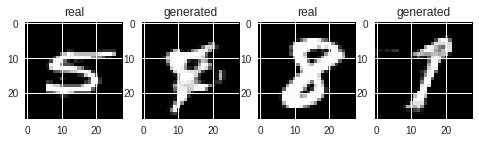


------------------------------------------------------------------------------
At step: 7900 , with variance of noise = Tensor("PolynomialDecay:0", shape=(), dtype=float32)
G loss = 0.97626567
D loss = 0.5595533

Without Noise


KeyboardInterrupt: ignored

In [12]:
training()